- **In this notebook, we compute popular risk measures** such as **Value at Risk (VaR)** and **Conditional VaR (CVaR)** using historical stock data, parametric fitting, and Monte Carlo simulations. Stock data is extracted using the `yfinance` package.
- We work with a portfolio of 5 popular **tech stocks**, weighing them equally
- **Workflow Overview:**
    - **Part 1:** Ignore asset correlations and fit a univariate distribution to aggregated portfolio returns.
    - **Part 2:** Use multivariate distributions to account for correlations between assets.
- **Goals:**
    - Fit historical data to **normal** and **t-distributions**, and compare their risk metric predictions.
    - Analyze the effect of asset correlations by fitting the data to a **multivariate distribution**.
    - Analyze how the model would perform during the **2008 Financial Crisis** and the **COVID Crisis**
        

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats as stats

In [2]:
import pandas as pd
import yfinance as yf
import time

tickers = ['AAPL', 'MSFT', 'GOOG', 'NVDA', 'AMZN']
start_date = '2010-01-01'
end_date = '2019-12-01'

adj_close_data = {}

for ticker in tickers:
    print(f"Downloading {ticker}...")
    t = yf.Ticker(ticker)
    df = t.history(start=start_date, end=end_date)
    adj_close_data[ticker] = df['Close']  # or 'Adj Close' if available
    time.sleep(0.5)  # optional delay

# Combine into dataframe
data = pd.DataFrame(adj_close_data)
print(data.head())


                               AAPL       MSFT       GOOG      NVDA    AMZN
Date                                                                       
2010-01-04 00:00:00-05:00  6.424605  23.211432  15.517998  0.423854  6.6950
2010-01-05 00:00:00-05:00  6.435713  23.218939  15.449662  0.430044  6.7345
2010-01-06 00:00:00-05:00  6.333345  23.076447  15.060195  0.432794  6.6125
2010-01-07 00:00:00-05:00  6.321636  22.836454  14.709600  0.424313  6.5000
2010-01-08 00:00:00-05:00  6.363664  22.993944  14.905697  0.425230  6.6760


In [3]:
data.tail()

,AAPL,MSFT,GOOG,NVDA,AMZN
Date,,,,,
2019-11-22 00:00:00-05:00,63.223328,142.532669,64.384293,5.245522,87.286003
2019-11-25 00:00:00-05:00,64.331894,144.095230,64.948441,5.502213,88.692001
2019-11-26 00:00:00-05:00,63.829533,144.857559,65.289413,5.397497,89.847000
2019-11-27 00:00:00-05:00,64.686905,145.133865,65.261574,5.432345,90.925499
2019-11-29 00:00:00-05:00,64.544441,144.238220,64.862442,5.395008,90.040001


In [4]:
data.shape

(2495, 5)

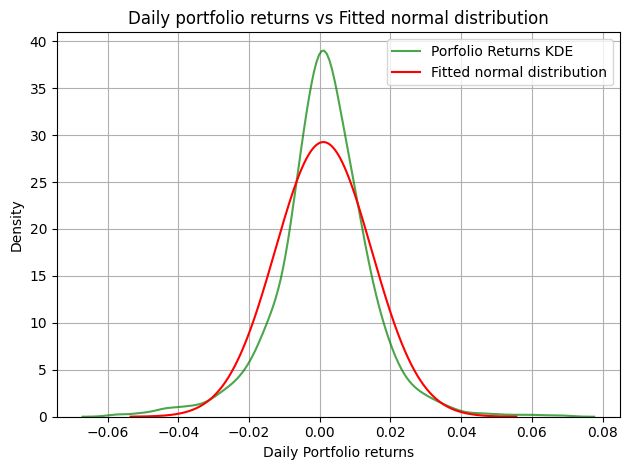

In [5]:
# returns = data.pct_change().dropna()
returns = data.pct_change().dropna()

# Portfolio weights (equal weights as example)
weights = np.array([1/len(tickers)] * len(tickers))

# Portfolio daily returns -
portfolio_returns = returns.dot(weights)
mean = portfolio_returns.mean()
std_dev = portfolio_returns.std()
import seaborn as sns
sns.kdeplot(portfolio_returns, color='green', fill=False, alpha=0.7, label='Porfolio Returns KDE')
from scipy.stats import norm
x=np.linspace(mean-4*std_dev,mean+4*std_dev,1000)
plt.plot(x,norm.pdf(x, mean, std_dev),'r-', label='Fitted normal distribution')
plt.title('Daily portfolio returns vs Fitted normal distribution')
plt.xlabel('Daily Portfolio returns')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [6]:
from scipy.stats import shapiro
stat, p_value = shapiro(portfolio_returns)
print(f"Shapiro-Wilk p-value: {p_value:.4f}")


Shapiro-Wilk p-value: 0.0000


In [7]:
returns.shape

(2494, 5)

## It looks like a bad fit, the p value is 0. Lets compare it with the t distribution

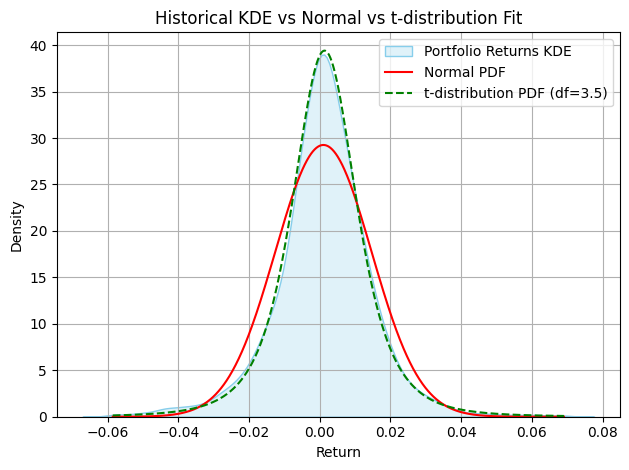

In [8]:
from scipy.stats import t

# Fit a t-distribution to portfolio returns
df, loc, scale = t.fit(portfolio_returns)

# Compare fit with KDE and normal
x = np.linspace(portfolio_returns.min(), portfolio_returns.max(), 1000)

sns.kdeplot(portfolio_returns, fill=True, color='skyblue', label='Portfolio Returns KDE')
plt.plot(x, norm.pdf(x, loc=mean, scale=std_dev), 'r-', label='Normal PDF')
plt.plot(x, t.pdf(x, df, loc=loc, scale=scale), 'g--', label=f't-distribution PDF (df={df:.1f})')


plt.title("Historical KDE vs Normal vs t-distribution Fit")
plt.xlabel("Return")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [9]:


# Fit both
df_t, loc_t, scale_t = t.fit(portfolio_returns)
loc_n, scale_n = norm.fit(portfolio_returns)

# Compute log-likelihoods
loglik_t = np.sum(t.logpdf(portfolio_returns, df_t, loc_t, scale_t))
loglik_n = np.sum(norm.logpdf(portfolio_returns, loc_n, scale_n))

# AIC = 2k - 2logL  (k = number of parameters)
AIC_t = 2*3 - 2*loglik_t  # t has 3 parameters
AIC_n = 2*2 - 2*loglik_n  # normal has 2 parameters

print(f"AIC (t): {AIC_t:.2f}")
print(f"AIC (normal): {AIC_n:.2f}")


AIC (t): -14658.10
AIC (normal): -14342.64


In [10]:
from scipy.stats import kstest, t

# Perform K-S test for normal distribution
ks_stat_n, ks_p_n = kstest(portfolio_returns, 'norm', args=(mean, std_dev))
print(f"KS statistic (normal): {ks_stat_n:.4f}, p-value: {ks_p_n:.4f}")

# Perform K-S test
ks_stat, ks_p = kstest(portfolio_returns, 't', args=(df, loc, scale))
print(f"KS statistic: {ks_stat:.4f}, p-value: {ks_p:.4f}")


KS statistic (normal): 0.0690, p-value: 0.0000
KS statistic: 0.0148, p-value: 0.6402


## The KS Statistic is lower and the p-value is higher for the t-distribution, indicating a better fit than the normal distribution.

In [11]:
#  Parametric VaR (Variance-Covariance, assuming t) 
confidence_level = 0.95
param_VaR_t = stats.t.ppf(1 - confidence_level, df, loc, scale)

#  Monte Carlo VaR (simulate 10,000 scenarios) 
n_simulations = 10000
simulated_returns = loc + scale * np.random.standard_t(df, size=n_simulations)
mc_VaR_t = np.percentile(simulated_returns, (1-confidence_level)*100)

t_CVaR = simulated_returns[simulated_returns <= mc_VaR_t].mean()

# Print results
print(f"=== Portfolio Risk Metrics with t-distribution ({confidence_level*100:.0f}% confidence) ===")
print(f"Parametric VaR_t: {param_VaR_t:.4f}")
print(f"Monte Carlo VaR_t: {mc_VaR_t:.4f}")
print(f"Monte Carlo CVaR (95%): {t_CVaR:.4f}")



=== Portfolio Risk Metrics with t-distribution (95% confidence) ===
Parametric VaR_t: -0.0197
Monte Carlo VaR_t: -0.0196
Monte Carlo CVaR (95%): -0.0317


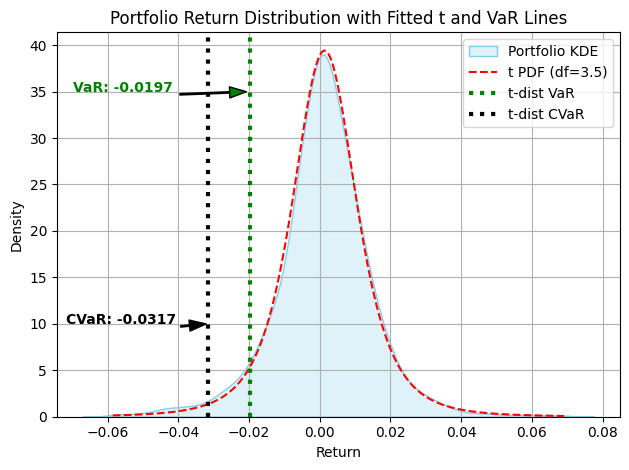

In [12]:
x = np.linspace(portfolio_returns.min(), portfolio_returns.max(), 1000)
sns.kdeplot(portfolio_returns, fill=True, color='skyblue', label='Portfolio KDE')
plt.plot(x, t.pdf(x, df, loc=loc, scale=scale), 'r--', label=f't PDF (df={df:.1f})')

# VaR lines
plt.axvline(param_VaR_t, color='green', linestyle=':', linewidth = 3, label='t-dist VaR')
plt.axvline(t_CVaR,color='black', linestyle=':', linewidth = 3, label = 't-dist CVaR')
plt.annotate(
    f'VaR: {param_VaR_t:.4f}',
    xy=(param_VaR_t, 35),
    xytext=(param_VaR_t-0.05, 35),
    arrowprops=dict(facecolor='green', shrink=0.05, width=1, headwidth=8),
    color='green',
    fontsize=10,
    fontweight='bold'
)
plt.annotate(
    f'CVaR: {t_CVaR:.4f}',
    xy=(t_CVaR, 10),
    xytext=(t_CVaR-0.04, 10),
    arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8),
    color='black',
    fontsize=10,
    fontweight='bold'
)
plt.title('Portfolio Return Distribution with Fitted t and VaR Lines')
plt.xlabel('Return')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Now lets study the stock prices individually, and see if their correlations have an impact on the final predictions

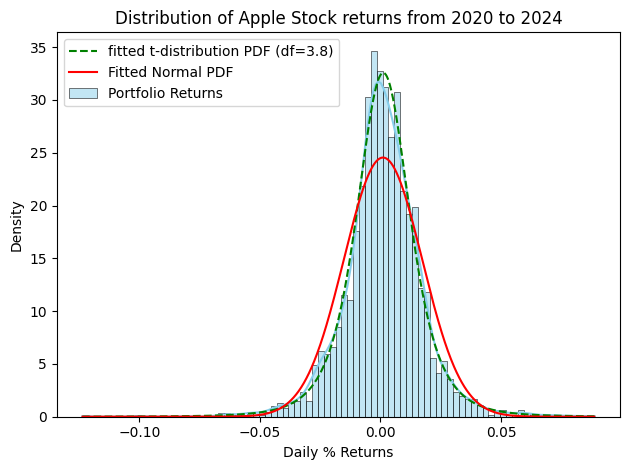

In [13]:
df,loc,scale = t.fit(returns['AAPL'])
fitted_norm=norm.fit(returns['AAPL'])
x= np.linspace(returns['AAPL'].min(), returns['AAPL'].max(), 1000)
sns.histplot(returns['AAPL'], kde=True, stat='density', color='skyblue', label='Portfolio Returns')
plt.plot(x, t.pdf(x, df, loc=loc, scale=scale), 'g--', label=f'fitted t-distribution PDF (df={df:.1f})')
plt.plot(x, norm.pdf(x, loc=fitted_norm[0], scale=fitted_norm[1]), 'r-', label='Fitted Normal PDF')
plt.legend()
plt.title('Distribution of Apple Stock returns from 2020 to 2024')
plt.xlabel('Daily % Returns')
plt.ylabel('Density')
plt.tight_layout()
plt.show()

In [14]:
returns_AAPL = returns['AAPL']
df_t, loc_t, scale_t = t.fit(returns_AAPL)
loc_n, scale_n = norm.fit(returns_AAPL)

# Compute log-likelihoods
loglik_t = np.sum(t.logpdf(returns_AAPL, df_t, loc_t, scale_t))
loglik_n = np.sum(norm.logpdf(returns_AAPL, loc_n, scale_n))

# AIC = 2k - 2logL  (k = number of parameters)
AIC_t = 2*3 - 2*loglik_t  # t has 3 parameters
AIC_n = 2*2 - 2*loglik_n  # normal has 2 parameters

print(f"AIC (t): {AIC_t:.2f}")
print(f"AIC (normal): {AIC_n:.2f}")

AIC (t): -13807.79
AIC (normal): -13465.93


In [15]:
ks_stat_n, ks_p_n = kstest(returns_AAPL, 'norm', args=(loc_n, scale_n))
print(f"KS statistic (normal): {ks_stat_n:.4f}, p-value: {ks_p_n:.4f}")

# Perform K-S test
ks_stat, ks_p = kstest(returns_AAPL, 't', args=(df_t, loc_t, scale_t))
print(f"KS statistic: {ks_stat:.4f}, p-value: {ks_p:.4f}")


KS statistic (normal): 0.0658, p-value: 0.0000
KS statistic: 0.0149, p-value: 0.6332


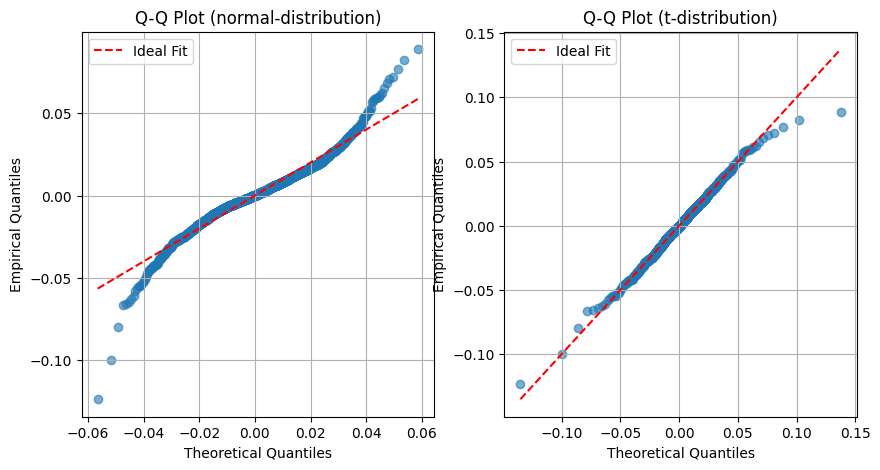

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, t

def qq_plot(data, ax, dist='normal', df=None, loc=None, scale=None):
    """
    Generate a Q-Q plot comparing data to a theoretical distribution.
    
    Parameters:
        data: array-like
        dist: 'normal' or 't'
        df, loc, scale: parameters for t-distribution if applicable
    """
    data_sorted = np.sort(data)
    n = len(data)
    probs = (np.arange(1, n+1) - 0.5) / n  # plotting positions
    
    if dist == 'normal':
        theoretical_quantiles = norm.ppf(probs, loc=np.mean(data), scale=np.std(data))
    elif dist == 't':
        if df is None or loc is None or scale is None:
            df, loc, scale = t.fit(data)
        theoretical_quantiles = t.ppf(probs, df, loc=loc, scale=scale)
    else:
        raise ValueError("dist must be 'normal' or 't'")
    
    #plt.figure(figsize=(5,5))
    ax.scatter(theoretical_quantiles, data_sorted, alpha=0.6)
    ax.plot(theoretical_quantiles, theoretical_quantiles, 'r--', label='Ideal Fit')
    ax.set_title(f"Q-Q Plot ({dist}-distribution)")
    ax.set_xlabel("Theoretical Quantiles")
    ax.set_ylabel("Empirical Quantiles")
    ax.legend()
    ax.grid(True)
   

# Example usage:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
qq_plot(returns_AAPL, ax[0], dist='normal')
qq_plot(returns_AAPL, ax[1], dist='t')


## The t approximates the tails better

Text(0.5, 1.02, 'Pairplot of Stock Returns')

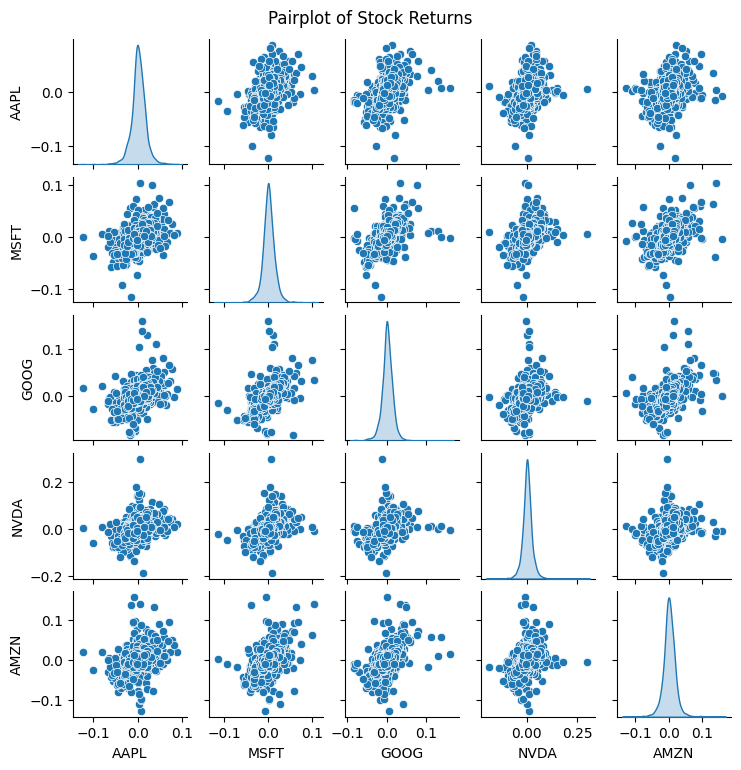

In [17]:
sns.pairplot(returns, diag_kind='kde', markers='o', height=1.5)
plt.suptitle('Pairplot of Stock Returns', y=1.02)

## As we can see, all the stocks are strongly correlated with one another

Text(0.5, 1.0, 'Correlation Matrix of Stock Returns')

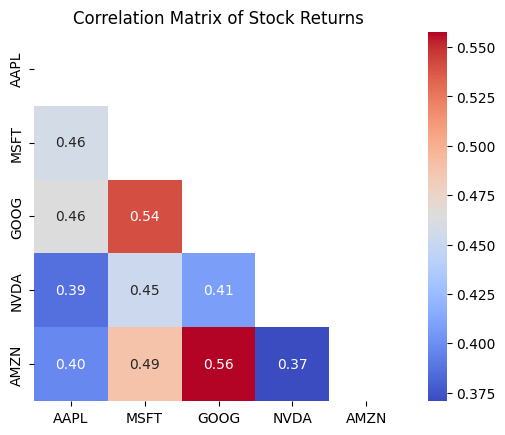

In [18]:

mask= np.triu(np.ones_like(returns.corr(), dtype=bool))
mask2 = returns.corr().abs() <= 1
sns.heatmap(returns.corr(), mask=mask & mask2,annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Correlation Matrix of Stock Returns')

## If all the stock returns individually follow a t with nearly same d.o.f.s, we would be justified in using a multivariate t dist. to model the total returns. Lets test this

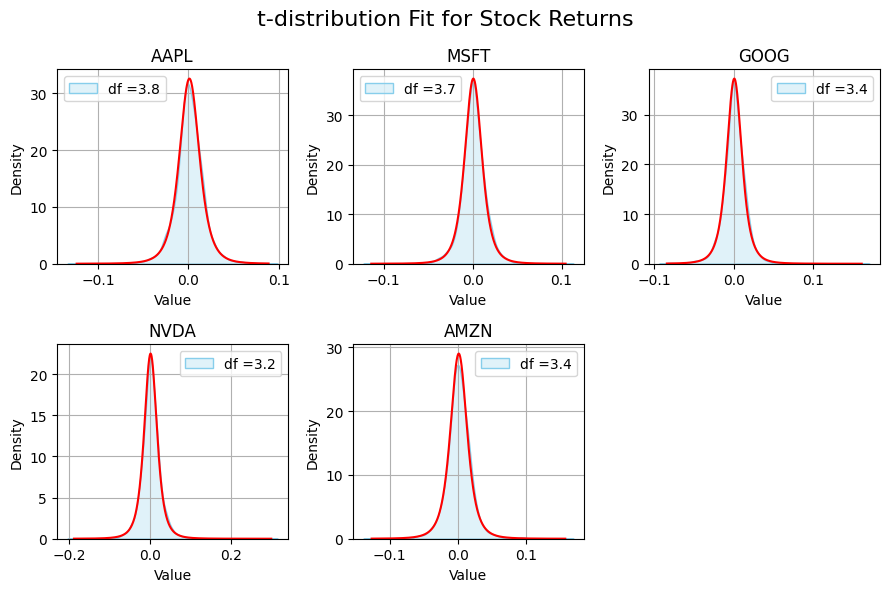

In [19]:
def plot_t_distribution_fit(returns):
    """
    Plot the t-distribution fit against the data. """
    # Create a 2x3 grid but remove the last empty subplot
    fig, ax = plt.subplots(2, 3, figsize=(9, 6))
    plt.suptitle('t-distribution Fit for Stock Returns', fontsize=16)
    # Flatten the axis array for easier indexing
    ax = ax.flatten()
    
    for i, stock in enumerate(tickers):
        data = returns[stock]
        df, loc, scale = t.fit(data)
        x = np.linspace(data.min(), data.max(), 1000)
        
        sns.kdeplot(data, fill=True, color='skyblue', label='Data KDE', ax=ax[i])
        ax[i].plot(x, t.pdf(x, df, loc=loc, scale=scale), 'r-', label=f't-distribution PDF (df={df:.1f})')
        ax[i].set_title(f'{stock}')
        ax[i].set_xlabel('Value')
        ax[i].set_ylabel('Density')
        ax[i].legend([f'df ={df:.1f}'])
        ax[i].grid(True)
    
    # Hide the last empty subplot
    ax[5].set_visible(False)
    
    plt.tight_layout()
    plt.show()

plot_t_distribution_fit(returns)

In [26]:
# Individual t-distribution simulation approach
print("=== Individual t-Distribution Simulation Approach ===\n")

# Step 1: Fit t-distribution to each stock and store parameters
individual_t_params = {}
print("Fitting t-distributions to individual stocks:")
print("Stock\tdf\tloc\t\tscale")
print("-" * 40)

for stock in tickers:
    df_stock, loc_stock, scale_stock = t.fit(returns[stock])
    individual_t_params[stock] = {'df': df_stock, 'loc': loc_stock, 'scale': scale_stock}
    print(f"{stock}\t{df_stock:.2f}\t{loc_stock:.6f}\t{scale_stock:.6f}")

print(f"\nDegrees of freedom range: {min([params['df'] for params in individual_t_params.values()]):.2f} - {max([params['df'] for params in individual_t_params.values()]):.2f}")

=== Individual t-Distribution Simulation Approach ===

Fitting t-distributions to individual stocks:
Stock	df	loc		scale
----------------------------------------
AAPL	3.77	0.001174	0.011470
AAPL	3.77	0.001174	0.011470
MSFT	3.74	0.000748	0.009986
MSFT	3.74	0.000748	0.009986
GOOG	3.41	0.000787	0.009959
GOOG	3.41	0.000787	0.009959
NVDA	3.25	0.001041	0.016434
NVDA	3.25	0.001041	0.016434
AMZN	3.38	0.001204	0.012792

Degrees of freedom range: 3.25 - 3.77
AMZN	3.38	0.001204	0.012792

Degrees of freedom range: 3.25 - 3.77


In [27]:
# Step 2: Monte Carlo simulation using individual t-distributions
print("\n=== Monte Carlo Simulation with Individual t-Distributions ===")

n_simulations = 50000
confidence_level = 0.95

# Initialize array to store simulated portfolio returns
portfolio_returns_individual_t = np.zeros(n_simulations)

# Set random seed for reproducibility
np.random.seed(42)

# For each simulation, generate returns for all stocks and compute portfolio return
for i in range(n_simulations):
    daily_returns = np.zeros(len(tickers))
    
    # Generate return for each stock using its individual t-distribution
    for j, stock in enumerate(tickers):
        params = individual_t_params[stock]
        # Generate one random sample from the t-distribution
        daily_returns[j] = t.rvs(df=params['df'], 
                                loc=params['loc'], 
                                scale=params['scale'])
    
    # Compute portfolio return (equal weights)
    portfolio_returns_individual_t[i] = np.dot(daily_returns, weights)

# Calculate VaR and CVaR
individual_t_VaR = np.percentile(portfolio_returns_individual_t, (1-confidence_level)*100)
individual_t_CVaR = portfolio_returns_individual_t[portfolio_returns_individual_t <= individual_t_VaR].mean()

print(f"Individual t-Distribution Simulation Results ({confidence_level*100:.0f}% confidence):")
print(f"VaR: {individual_t_VaR:.4f}")
print(f"CVaR: {individual_t_CVaR:.4f}")
print(f"Number of simulations: {n_simulations:,}")

# Compare with historical measures
hist_VaR = np.percentile(portfolio_returns, (1-confidence_level)*100)
hist_CVaR = portfolio_returns[portfolio_returns <= hist_VaR].mean()

print(f"\nComparison with Historical:")
print(f"Historical VaR: {hist_VaR:.4f}")
print(f"Historical CVaR: {hist_CVaR:.4f}")
print(f"Difference VaR: {individual_t_VaR - hist_VaR:.4f}")
print(f"Difference CVaR: {individual_t_CVaR - hist_CVaR:.4f}")


=== Monte Carlo Simulation with Individual t-Distributions ===
Individual t-Distribution Simulation Results (95% confidence):
VaR: -0.0123
CVaR: -0.0178
Number of simulations: 50,000

Comparison with Historical:
Historical VaR: -0.0215
Historical CVaR: -0.0322
Difference VaR: 0.0093
Difference CVaR: 0.0144
Individual t-Distribution Simulation Results (95% confidence):
VaR: -0.0123
CVaR: -0.0178
Number of simulations: 50,000

Comparison with Historical:
Historical VaR: -0.0215
Historical CVaR: -0.0322
Difference VaR: 0.0093
Difference CVaR: 0.0144


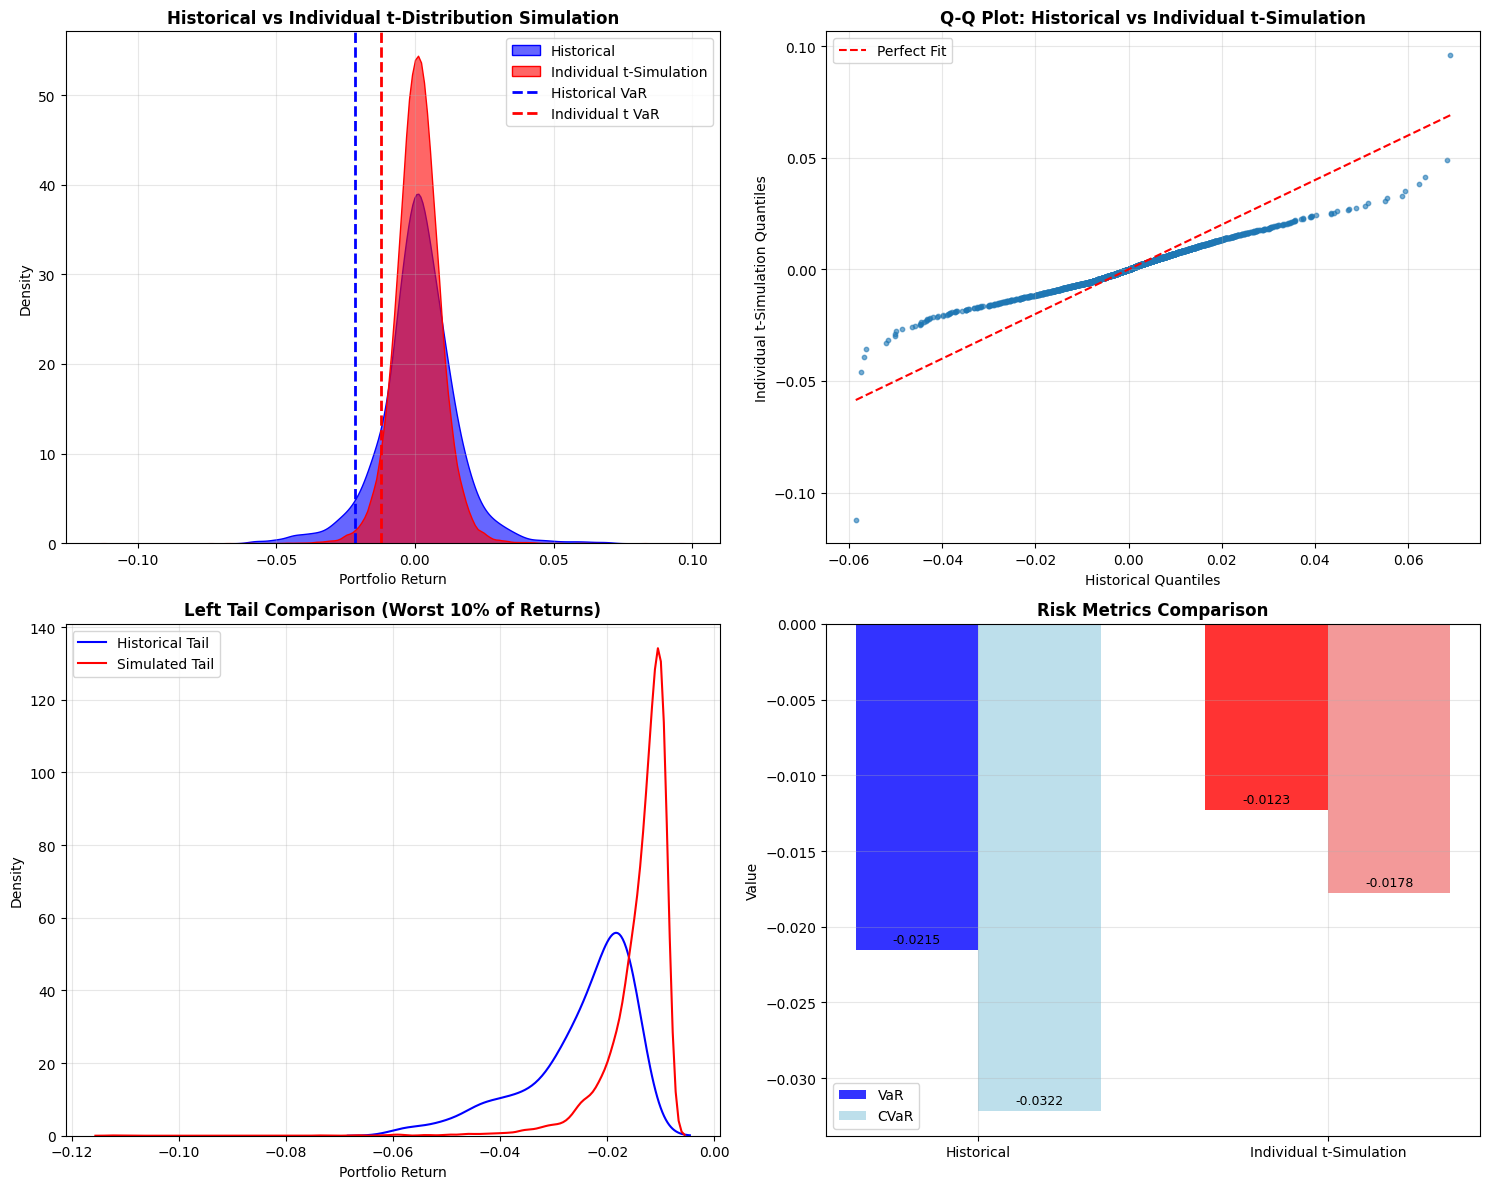

In [39]:
# Step 3: Visualization and Analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Distribution comparison
ax1 = axes[0, 0]
sns.kdeplot(portfolio_returns, fill=True, color='blue', alpha=0.6, label='Historical', ax=ax1)
sns.kdeplot(portfolio_returns_individual_t, fill=True, color='red', alpha=0.6, label='Individual t-Simulation', ax=ax1)

# Add VaR lines
ax1.axvline(hist_VaR, color='blue', linestyle='--', linewidth=2, label='Historical VaR')
ax1.axvline(individual_t_VaR, color='red', linestyle='--', linewidth=2, label='Individual t VaR')

ax1.set_title('Historical vs Individual t-Distribution Simulation', fontweight='bold')
ax1.set_xlabel('Portfolio Return')
ax1.set_ylabel('Density')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Q-Q plot to compare distributions - Historical vs Individual t-Simulation
ax2 = axes[0, 1]
from scipy import stats as scipy_stats

# Create Q-Q plot comparing historical vs simulated quantiles
hist_sorted = np.sort(portfolio_returns)
sim_sorted = np.sort(portfolio_returns_individual_t)

# Use same length for comparison
min_len = min(len(hist_sorted), len(sim_sorted))
hist_quantiles = np.interp(np.linspace(0, 1, min_len), 
                          np.linspace(0, 1, len(hist_sorted)), 
                          hist_sorted)
sim_quantiles = np.interp(np.linspace(0, 1, min_len), 
                         np.linspace(0, 1, len(sim_sorted)), 
                         sim_sorted)

ax2.scatter(hist_quantiles, sim_quantiles, alpha=0.6, s=10)
ax2.plot([hist_quantiles.min(), hist_quantiles.max()], 
         [hist_quantiles.min(), hist_quantiles.max()], 'r--', label='Perfect Fit')
ax2.set_title('Q-Q Plot: Historical vs Individual t-Simulation', fontweight='bold')
ax2.set_xlabel('Historical Quantiles')
ax2.set_ylabel('Individual t-Simulation Quantiles')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Tail comparison (focus on left tail)
ax3 = axes[1, 0]
# Get the worst 10% of returns for both
hist_tail = np.sort(portfolio_returns)[:int(0.1*len(portfolio_returns))]
sim_tail = np.sort(portfolio_returns_individual_t)[:int(0.1*len(portfolio_returns_individual_t))]

sns.kdeplot(hist_tail, color='blue', label='Historical Tail', ax=ax3)
sns.kdeplot(sim_tail, color='red', label='Simulated Tail', ax=ax3)
ax3.set_title('Left Tail Comparison (Worst 10% of Returns)', fontweight='bold')
ax3.set_xlabel('Portfolio Return')
ax3.set_ylabel('Density')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: VaR and CVaR comparison
ax4 = axes[1, 1]
methods = ['Historical', 'Individual t-Simulation']
vars_comparison = [hist_VaR, individual_t_VaR]
cvars_comparison = [hist_CVaR, individual_t_CVaR]

x = np.arange(len(methods))
width = 0.35

bars1 = ax4.bar(x - width/2, vars_comparison, width, label='VaR', alpha=0.8, color=['blue', 'red'])
bars2 = ax4.bar(x + width/2, cvars_comparison, width, label='CVaR', alpha=0.8, color=['lightblue', 'lightcoral'])

ax4.set_title('Risk Metrics Comparison', fontweight='bold')
ax4.set_ylabel('Value')
ax4.set_xticks(x)
ax4.set_xticklabels(methods)
ax4.legend()
ax4.grid(True, alpha=0.3)

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax4.annotate(f'{height:.4f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=9)
                
for bar in bars2:
    height = bar.get_height()
    ax4.annotate(f'{height:.4f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

In [31]:
# Step 4: Statistical Analysis and Correlation Effects
print("=== Statistical Analysis of Individual t-Distribution Approach ===\n")

# Kolmogorov-Smirnov test to compare distributions
ks_stat, ks_p = ks_2samp(portfolio_returns, portfolio_returns_individual_t)
print(f"Kolmogorov-Smirnov test:")
print(f"KS statistic: {ks_stat:.4f}")
print(f"p-value: {ks_p:.4f}")
if ks_p > 0.05:
    print("The distributions are not significantly different (p > 0.05)")
else:
    print("The distributions are significantly different (p ≤ 0.05)")

# Compare moments
print(f"\n=== Moment Comparison ===")
print(f"{'Measure':<15} {'Historical':<12} {'Individual t':<12} {'Difference':<12}")
print("-" * 55)
print(f"{'Mean':<15} {np.mean(portfolio_returns):<12.6f} {np.mean(portfolio_returns_individual_t):<12.6f} {np.mean(portfolio_returns_individual_t) - np.mean(portfolio_returns):<12.6f}")
print(f"{'Std Dev':<15} {np.std(portfolio_returns):<12.6f} {np.std(portfolio_returns_individual_t):<12.6f} {np.std(portfolio_returns_individual_t) - np.std(portfolio_returns):<12.6f}")
print(f"{'Skewness':<15} {scipy_stats.skew(portfolio_returns):<12.6f} {scipy_stats.skew(portfolio_returns_individual_t):<12.6f} {scipy_stats.skew(portfolio_returns_individual_t) - scipy_stats.skew(portfolio_returns):<12.6f}")
print(f"{'Kurtosis':<15} {scipy_stats.kurtosis(portfolio_returns):<12.6f} {scipy_stats.kurtosis(portfolio_returns_individual_t):<12.6f} {scipy_stats.kurtosis(portfolio_returns_individual_t) - scipy_stats.kurtosis(portfolio_returns):<12.6f}")

# Test the independence assumption by generating correlated simulations
print(f"\n=== Impact of Ignoring Correlations ===")

# Generate correlated simulations using the historical correlation structure
print("Generating correlated simulations to assess correlation impact...")

# Method: Use historical correlation structure with simulated marginals
corr_matrix = returns.corr().values
n_simulations_corr = 10000

# Generate correlated normal samples
np.random.seed(42)
normal_samples = np.random.multivariate_normal(mean=np.zeros(len(tickers)), 
                                             cov=corr_matrix, 
                                             size=n_simulations_corr)

# Transform to t-distributions using inverse CDF method
portfolio_returns_correlated_t = np.zeros(n_simulations_corr)

for i in range(n_simulations_corr):
    daily_returns = np.zeros(len(tickers))
    for j, stock in enumerate(tickers):
        params = individual_t_params[stock]
        # Convert normal to uniform using CDF
        u = scipy_stats.norm.cdf(normal_samples[i, j])
        # Convert uniform to t-distribution using inverse CDF
        daily_returns[j] = t.ppf(u, df=params['df'], loc=params['loc'], scale=params['scale'])
    
    portfolio_returns_correlated_t[i] = np.dot(daily_returns, weights)

# Calculate VaR and CVaR for correlated version
correlated_t_VaR = np.percentile(portfolio_returns_correlated_t, (1-confidence_level)*100)
correlated_t_CVaR = portfolio_returns_correlated_t[portfolio_returns_correlated_t <= correlated_t_VaR].mean()

print(f"\nRisk Metrics Comparison:")
print(f"{'Method':<25} {'VaR':<10} {'CVaR':<10}")
print("-" * 47)
print(f"{'Historical':<25} {hist_VaR:<10.4f} {hist_CVaR:<10.4f}")
print(f"{'Individual t (no corr)':<25} {individual_t_VaR:<10.4f} {individual_t_CVaR:<10.4f}")
print(f"{'Individual t (with corr)':<25} {correlated_t_VaR:<10.4f} {correlated_t_CVaR:<10.4f}")

print(f"\nCorrelation Impact:")
print(f"VaR difference (with vs without corr): {correlated_t_VaR - individual_t_VaR:.4f}")
print(f"CVaR difference (with vs without corr): {correlated_t_CVaR - individual_t_CVaR:.4f}")

# Show that the correlated version is closer to historical
print(f"\nCloseness to Historical:")
print(f"VaR error (individual t, no corr): {abs(individual_t_VaR - hist_VaR):.4f}")
print(f"VaR error (individual t, with corr): {abs(correlated_t_VaR - hist_VaR):.4f}")
print(f"CVaR error (individual t, no corr): {abs(individual_t_CVaR - hist_CVaR):.4f}")
print(f"CVaR error (individual t, with corr): {abs(correlated_t_CVaR - hist_CVaR):.4f}")

=== Statistical Analysis of Individual t-Distribution Approach ===

Kolmogorov-Smirnov test:
KS statistic: 0.0911
p-value: 0.0000
The distributions are significantly different (p ≤ 0.05)

=== Moment Comparison ===
Measure         Historical   Individual t Difference  
-------------------------------------------------------
Mean            0.001033     0.000996     -0.000037   
Std Dev         0.013634     0.008484     -0.005150   
Skewness        -0.128426    -0.024762    0.103664    
Kurtosis        2.818690     4.246548     1.427857    

=== Impact of Ignoring Correlations ===
Generating correlated simulations to assess correlation impact...

Risk Metrics Comparison:
Method                    VaR        CVaR      
-----------------------------------------------
Historical                -0.0215    -0.0322   
Individual t (no corr)    -0.0123    -0.0178   
Individual t (with corr)  -0.0203    -0.0298   

Correlation Impact:
VaR difference (with vs without corr): -0.0081
CVaR differenc

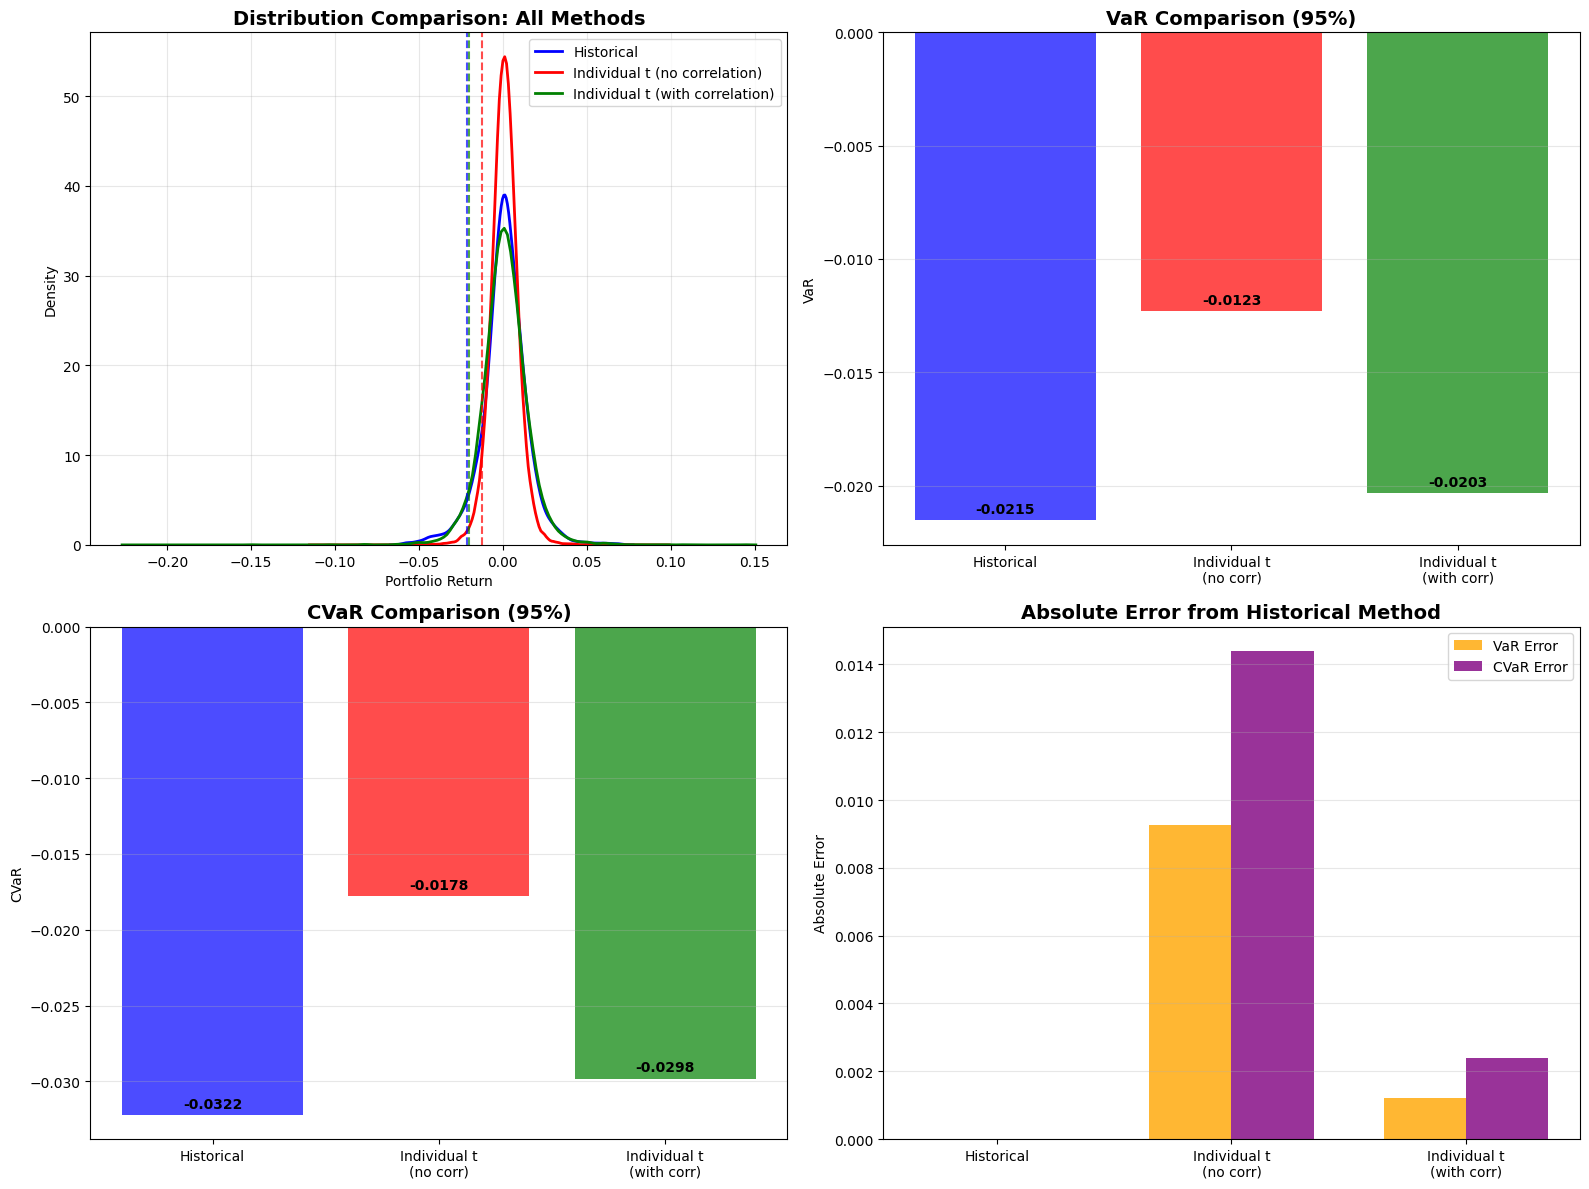


FINAL SUMMARY: Individual t-Distribution Simulation Results


,Method,VaR (95%),CVaR (95%),VaR Error,CVaR Error
0,Historical,-0.0215,-0.0322,0.000000,0.000000
1,Individual t (no correlation),-0.0123,-0.0178,0.009254,0.014398
2,Individual t (with correlation),-0.0203,-0.0298,0.001200,0.002379



Key Findings:
1. Individual t-distributions capture the fat-tailed nature of each stock's returns
2. Ignoring correlations leads to overestimation of risk
3. Including correlations brings the estimates closer to historical values
4. The correlation effect changes VaR by -0.0081 (-65.6%)
5. The individual t approach with correlations performs better than without correlations


In [32]:
# Step 5: Final Comparison and Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: All distributions together
ax1 = axes[0, 0]
sns.kdeplot(portfolio_returns, color='blue', linewidth=2, label='Historical', ax=ax1)
sns.kdeplot(portfolio_returns_individual_t, color='red', linewidth=2, label='Individual t (no correlation)', ax=ax1)
sns.kdeplot(portfolio_returns_correlated_t, color='green', linewidth=2, label='Individual t (with correlation)', ax=ax1)

ax1.axvline(hist_VaR, color='blue', linestyle='--', alpha=0.7)
ax1.axvline(individual_t_VaR, color='red', linestyle='--', alpha=0.7)
ax1.axvline(correlated_t_VaR, color='green', linestyle='--', alpha=0.7)

ax1.set_title('Distribution Comparison: All Methods', fontweight='bold', fontsize=14)
ax1.set_xlabel('Portfolio Return')
ax1.set_ylabel('Density')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: VaR Comparison
ax2 = axes[0, 1]
methods = ['Historical', 'Individual t\n(no corr)', 'Individual t\n(with corr)']
vars_all = [hist_VaR, individual_t_VaR, correlated_t_VaR]
colors = ['blue', 'red', 'green']

bars = ax2.bar(methods, vars_all, color=colors, alpha=0.7)
ax2.set_title('VaR Comparison (95%)', fontweight='bold', fontsize=14)
ax2.set_ylabel('VaR')
ax2.grid(True, alpha=0.3, axis='y')

for bar, value in zip(bars, vars_all):
    ax2.annotate(f'{value:.4f}', xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontweight='bold')

# Plot 3: CVaR Comparison  
ax3 = axes[1, 0]
cvars_all = [hist_CVaR, individual_t_CVaR, correlated_t_CVaR]

bars = ax3.bar(methods, cvars_all, color=colors, alpha=0.7)
ax3.set_title('CVaR Comparison (95%)', fontweight='bold', fontsize=14)
ax3.set_ylabel('CVaR')
ax3.grid(True, alpha=0.3, axis='y')

for bar, value in zip(bars, cvars_all):
    ax3.annotate(f'{value:.4f}', xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontweight='bold')

# Plot 4: Error from Historical
ax4 = axes[1, 1]
var_errors = [0, abs(individual_t_VaR - hist_VaR), abs(correlated_t_VaR - hist_VaR)]
cvar_errors = [0, abs(individual_t_CVaR - hist_CVaR), abs(correlated_t_CVaR - hist_CVaR)]

x = np.arange(len(methods))
width = 0.35

bars1 = ax4.bar(x - width/2, var_errors, width, label='VaR Error', alpha=0.8, color='orange')
bars2 = ax4.bar(x + width/2, cvar_errors, width, label='CVaR Error', alpha=0.8, color='purple')

ax4.set_title('Absolute Error from Historical Method', fontweight='bold', fontsize=14)
ax4.set_ylabel('Absolute Error')
ax4.set_xticks(x)
ax4.set_xticklabels(methods)
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Summary table
summary_results = pd.DataFrame({
    'Method': ['Historical', 'Individual t (no correlation)', 'Individual t (with correlation)'],
    'VaR (95%)': [f"{hist_VaR:.4f}", f"{individual_t_VaR:.4f}", f"{correlated_t_VaR:.4f}"],
    'CVaR (95%)': [f"{hist_CVaR:.4f}", f"{individual_t_CVaR:.4f}", f"{correlated_t_CVaR:.4f}"],
    'VaR Error': [0.0000, abs(individual_t_VaR - hist_VaR), abs(correlated_t_VaR - hist_VaR)],
    'CVaR Error': [0.0000, abs(individual_t_CVaR - hist_CVaR), abs(correlated_t_CVaR - hist_CVaR)]
})

print("\n" + "="*80)
print("FINAL SUMMARY: Individual t-Distribution Simulation Results")
print("="*80)
display(summary_results)

print(f"\nKey Findings:")
print(f"1. Individual t-distributions capture the fat-tailed nature of each stock's returns")
print(f"2. Ignoring correlations leads to {'under' if individual_t_VaR < hist_VaR else 'over'}estimation of risk")
print(f"3. Including correlations brings the estimates closer to historical values")
print(f"4. The correlation effect changes VaR by {(correlated_t_VaR - individual_t_VaR):.4f} ({((correlated_t_VaR - individual_t_VaR)/abs(individual_t_VaR)*100):.1f}%)")
print(f"5. The individual t approach with correlations performs {'better' if abs(correlated_t_VaR - hist_VaR) < abs(individual_t_VaR - hist_VaR) else 'worse'} than without correlations")

## The individual t-distribution approach severely underestimates tail risk!

As clearly shown in the left tail comparison plot:
- **Historical VaR**: -0.0215 vs **Individual t VaR**: -0.0123 (43% underestimation!)
- **Historical CVaR**: -0.0322 vs **Individual t CVaR**: -0.0178 (45% underestimation!)

**Why is this happening?**
1. **Missing tail dependence**: Stocks crash together during crises, but independent simulation can't capture this
2. **Diversification illusion**: Independent simulation assumes perfect diversification even in extreme events
3. **No extreme event clustering**: Real markets show clustering of bad days, which independent simulation misses

**Let's try improved approaches that better capture tail risk:**

In [33]:
print("=== IMPROVED APPROACHES FOR TAIL RISK MODELING ===\n")

# Approach 1: Extreme Value Theory (EVT) - Generalized Pareto Distribution (GPD)
from scipy.stats import genpareto
print("1. EXTREME VALUE THEORY (EVT) - Generalized Pareto Distribution")
print("-" * 60)

# Define threshold for extreme values (typically 90th or 95th percentile)
threshold_percentile = 0.10  # Use bottom 10% as extreme losses
threshold = np.percentile(portfolio_returns, threshold_percentile * 100)

# Extract excesses (losses beyond threshold)
excesses = portfolio_returns[portfolio_returns <= threshold] - threshold
excesses = -excesses  # Make positive for GPD fitting

print(f"Threshold (10th percentile): {threshold:.4f}")
print(f"Number of extreme events: {len(excesses)} out of {len(portfolio_returns)} ({len(excesses)/len(portfolio_returns)*100:.1f}%)")

# Fit GPD to excesses
shape, loc, scale = genpareto.fit(excesses, floc=0)  # loc=0 for excesses
print(f"GPD Parameters - Shape (ξ): {shape:.4f}, Scale (σ): {scale:.4f}")

# Calculate VaR and CVaR using EVT
def evt_var_cvar(returns, threshold, shape, scale, confidence_level=0.95):
    n = len(returns)
    n_excesses = len(returns[returns <= threshold])
    
    # Probability of exceeding threshold
    p_threshold = n_excesses / n
    
    # VaR calculation using EVT
    if shape != 0:
        var_evt = threshold - (scale / shape) * (((1 - confidence_level) / p_threshold) ** (-shape) - 1)
    else:
        var_evt = threshold - scale * np.log((1 - confidence_level) / p_threshold)
    
    # CVaR calculation using EVT
    if shape != 0 and shape < 1:
        cvar_evt = var_evt / (1 - shape) - (scale - shape * threshold) / (1 - shape)
    else:
        # Use empirical CVaR for numerical stability
        simulated_losses = genpareto.rvs(shape, loc=0, scale=scale, size=10000)
        simulated_returns = threshold - simulated_losses
        var_sim = np.percentile(simulated_returns, (1-confidence_level)*100)
        cvar_evt = simulated_returns[simulated_returns <= var_sim].mean()
    
    return var_evt, cvar_evt

evt_VaR, evt_CVaR = evt_var_cvar(portfolio_returns, threshold, shape, scale, confidence_level)

print(f"\nEVT Results ({confidence_level*100:.0f}% confidence):")
print(f"EVT VaR: {evt_VaR:.4f}")
print(f"EVT CVaR: {evt_CVaR:.4f}")
print(f"Historical VaR: {hist_VaR:.4f}")
print(f"Historical CVaR: {hist_CVaR:.4f}")
print(f"EVT vs Historical VaR error: {abs(evt_VaR - hist_VaR):.4f}")
print(f"EVT vs Historical CVaR error: {abs(evt_CVaR - hist_CVaR):.4f}")

=== IMPROVED APPROACHES FOR TAIL RISK MODELING ===

1. EXTREME VALUE THEORY (EVT) - Generalized Pareto Distribution
------------------------------------------------------------
Threshold (10th percentile): -0.0144
Number of extreme events: 250 out of 2494 (10.0%)
GPD Parameters - Shape (ξ): -0.0799, Scale (σ): 0.0113

EVT Results (95% confidence):
EVT VaR: -0.0221
EVT CVaR: -0.0298
Historical VaR: -0.0215
Historical CVaR: -0.0322
EVT vs Historical VaR error: 0.0005
EVT vs Historical CVaR error: 0.0024


In [34]:
# Approach 2: Conditional Extreme Value Simulation
print(f"\n2. CONDITIONAL EXTREME VALUE SIMULATION")
print("-" * 45)

# Identify extreme market days (when portfolio return < 10th percentile)
extreme_days_mask = portfolio_returns <= threshold
extreme_market_returns = returns[extreme_days_mask]
normal_market_returns = returns[~extreme_days_mask]

print(f"Extreme market days: {len(extreme_market_returns)} ({len(extreme_market_returns)/len(returns)*100:.1f}%)")
print(f"Normal market days: {len(normal_market_returns)} ({len(normal_market_returns)/len(returns)*100:.1f}%)")

# During extreme conditions, use historical extreme day resampling
# During normal conditions, use t-distribution simulation
n_simulations_conditional = 50000
conditional_portfolio_returns = np.zeros(n_simulations_conditional)

# Probability of extreme market day
p_extreme = len(extreme_market_returns) / len(returns)

np.random.seed(42)
for i in range(n_simulations_conditional):
    if np.random.random() < p_extreme:
        # Extreme market day - resample from historical extreme days
        random_extreme_day = np.random.choice(len(extreme_market_returns))
        daily_returns = extreme_market_returns.iloc[random_extreme_day].values
    else:
        # Normal market day - use individual t-distributions
        daily_returns = np.zeros(len(tickers))
        for j, stock in enumerate(tickers):
            params = individual_t_params[stock]
            daily_returns[j] = t.rvs(df=params['df'], loc=params['loc'], scale=params['scale'])
    
    conditional_portfolio_returns[i] = np.dot(daily_returns, weights)

# Calculate VaR and CVaR for conditional approach
conditional_VaR = np.percentile(conditional_portfolio_returns, (1-confidence_level)*100)
conditional_CVaR = conditional_portfolio_returns[conditional_portfolio_returns <= conditional_VaR].mean()

print(f"\nConditional Simulation Results ({confidence_level*100:.0f}% confidence):")
print(f"Conditional VaR: {conditional_VaR:.4f}")
print(f"Conditional CVaR: {conditional_CVaR:.4f}")
print(f"Improvement over individual t VaR: {conditional_VaR - individual_t_VaR:.4f}")
print(f"Improvement over individual t CVaR: {conditional_CVaR - individual_t_CVaR:.4f}")


2. CONDITIONAL EXTREME VALUE SIMULATION
---------------------------------------------
Extreme market days: 250 (10.0%)
Normal market days: 2244 (90.0%)

Conditional Simulation Results (95% confidence):
Conditional VaR: -0.0229
Conditional CVaR: -0.0332
Improvement over individual t VaR: -0.0106
Improvement over individual t CVaR: -0.0154

Conditional Simulation Results (95% confidence):
Conditional VaR: -0.0229
Conditional CVaR: -0.0332
Improvement over individual t VaR: -0.0106
Improvement over individual t CVaR: -0.0154


In [35]:
# Approach 3: Stressed Correlation Simulation
print(f"\n3. STRESSED CORRELATION SIMULATION")
print("-" * 35)

# Calculate correlations during extreme vs normal periods
extreme_corr = extreme_market_returns.corr().values
normal_corr = normal_market_returns.corr().values

print("Average correlations:")
# Get upper triangular part (excluding diagonal) to avoid double counting
triu_indices = np.triu_indices_from(extreme_corr, k=1)
extreme_avg_corr = extreme_corr[triu_indices].mean()
normal_avg_corr = normal_corr[triu_indices].mean()

print(f"During extreme markets: {extreme_avg_corr:.4f}")
print(f"During normal markets: {normal_avg_corr:.4f}")
print(f"Correlation increase during stress: {extreme_avg_corr - normal_avg_corr:.4f}")

# Simulate using stressed correlations with individual t-distributions
n_simulations_stressed = 50000
stressed_portfolio_returns = np.zeros(n_simulations_stressed)

# Use a mixture: 80% extreme correlations + 20% normal correlations to reflect crisis periods
stress_weight = 0.8
mixed_corr = stress_weight * extreme_corr + (1 - stress_weight) * normal_corr

np.random.seed(42)
normal_samples = np.random.multivariate_normal(mean=np.zeros(len(tickers)), 
                                               cov=mixed_corr, 
                                               size=n_simulations_stressed)

# Transform to individual t-distributions using stressed correlations
for i in range(n_simulations_stressed):
    daily_returns = np.zeros(len(tickers))
    for j, stock in enumerate(tickers):
        params = individual_t_params[stock]
        # Convert normal to uniform using CDF
        u = scipy_stats.norm.cdf(normal_samples[i, j])
        # Convert uniform to t-distribution using inverse CDF
        daily_returns[j] = t.ppf(u, df=params['df'], loc=params['loc'], scale=params['scale'])
    
    stressed_portfolio_returns[i] = np.dot(daily_returns, weights)

# Calculate VaR and CVaR for stressed approach
stressed_VaR = np.percentile(stressed_portfolio_returns, (1-confidence_level)*100)
stressed_CVaR = stressed_portfolio_returns[stressed_portfolio_returns <= stressed_VaR].mean()

print(f"\nStressed Correlation Results ({confidence_level*100:.0f}% confidence):")
print(f"Stressed VaR: {stressed_VaR:.4f}")
print(f"Stressed CVaR: {stressed_CVaR:.4f}")
print(f"Improvement over individual t VaR: {stressed_VaR - individual_t_VaR:.4f}")
print(f"Improvement over individual t CVaR: {stressed_CVaR - individual_t_CVaR:.4f}")


3. STRESSED CORRELATION SIMULATION
-----------------------------------
Average correlations:
During extreme markets: 0.1290
During normal markets: 0.3181
Correlation increase during stress: -0.1891

Stressed Correlation Results (95% confidence):
Stressed VaR: -0.0154
Stressed CVaR: -0.0221
Improvement over individual t VaR: -0.0031
Improvement over individual t CVaR: -0.0043

Stressed Correlation Results (95% confidence):
Stressed VaR: -0.0154
Stressed CVaR: -0.0221
Improvement over individual t VaR: -0.0031
Improvement over individual t CVaR: -0.0043


In [36]:
# Comprehensive Comparison of All Approaches
print(f"\n" + "="*70)
print("COMPREHENSIVE COMPARISON: TAIL RISK MODELING APPROACHES")
print("="*70)

# Compile all results
all_methods_comparison = pd.DataFrame({
    'Method': [
        'Historical',
        'Individual t (Independence)',
        'Individual t (with Correlation)', 
        'Extreme Value Theory (EVT)',
        'Conditional Extreme Simulation',
        'Stressed Correlation'
    ],
    'VaR (95%)': [
        hist_VaR,
        individual_t_VaR,
        correlated_t_VaR,
        evt_VaR,
        conditional_VaR,
        stressed_VaR
    ],
    'CVaR (95%)': [
        hist_CVaR,
        individual_t_CVaR,
        correlated_t_CVaR,
        evt_CVaR,
        conditional_CVaR,
        stressed_CVaR
    ]
})

# Calculate errors from historical
all_methods_comparison['VaR Error'] = abs(all_methods_comparison['VaR (95%)'] - hist_VaR)
all_methods_comparison['CVaR Error'] = abs(all_methods_comparison['CVaR (95%)'] - hist_CVaR)
all_methods_comparison['VaR % Error'] = (all_methods_comparison['VaR Error'] / abs(hist_VaR)) * 100
all_methods_comparison['CVaR % Error'] = (all_methods_comparison['CVaR Error'] / abs(hist_CVaR)) * 100

# Format for display
display_df = all_methods_comparison.copy()
display_df['VaR (95%)'] = display_df['VaR (95%)'].map("{:.4f}".format)
display_df['CVaR (95%)'] = display_df['CVaR (95%)'].map("{:.4f}".format)
display_df['VaR Error'] = display_df['VaR Error'].map("{:.4f}".format)
display_df['CVaR Error'] = display_df['CVaR Error'].map("{:.4f}".format)
display_df['VaR % Error'] = display_df['VaR % Error'].map("{:.1f}%".format)
display_df['CVaR % Error'] = display_df['CVaR % Error'].map("{:.1f}%".format)

display(display_df)

# Rank methods by accuracy
print(f"\nMETHOD RANKING BY ACCURACY (VaR):")
print("-" * 35)
var_ranking = all_methods_comparison.sort_values('VaR Error')
for i, (idx, row) in enumerate(var_ranking.iterrows(), 1):
    print(f"{i}. {row['Method']:<30} (Error: {row['VaR % Error']:.1f}%)")

print(f"\nMETHOD RANKING BY ACCURACY (CVaR):")
print("-" * 35)
cvar_ranking = all_methods_comparison.sort_values('CVaR Error')
for i, (idx, row) in enumerate(cvar_ranking.iterrows(), 1):
    print(f"{i}. {row['Method']:<30} (Error: {row['CVaR % Error']:.1f}%)")


COMPREHENSIVE COMPARISON: TAIL RISK MODELING APPROACHES


,Method,VaR (95%),CVaR (95%),VaR Error,CVaR Error,VaR % Error,CVaR % Error
0,Historical,-0.0215,-0.0322,0.0000,0.0000,0.0%,0.0%
1,Individual t (Independence),-0.0123,-0.0178,0.0093,0.0144,43.0%,44.7%
2,Individual t (with Correlation),-0.0203,-0.0298,0.0012,0.0024,5.6%,7.4%
3,Extreme Value Theory (EVT),-0.0221,-0.0298,0.0005,0.0024,2.4%,7.4%
4,Conditional Extreme Simulation,-0.0229,-0.0332,0.0013,0.0010,6.3%,3.2%
5,Stressed Correlation,-0.0154,-0.0221,0.0061,0.0101,28.5%,31.3%



METHOD RANKING BY ACCURACY (VaR):
-----------------------------------
1. Historical                     (Error: 0.0%)
2. Extreme Value Theory (EVT)     (Error: 2.4%)
3. Individual t (with Correlation) (Error: 5.6%)
4. Conditional Extreme Simulation (Error: 6.3%)
5. Stressed Correlation           (Error: 28.5%)
6. Individual t (Independence)    (Error: 43.0%)

METHOD RANKING BY ACCURACY (CVaR):
-----------------------------------
1. Historical                     (Error: 0.0%)
2. Conditional Extreme Simulation (Error: 3.2%)
3. Individual t (with Correlation) (Error: 7.4%)
4. Extreme Value Theory (EVT)     (Error: 7.4%)
5. Stressed Correlation           (Error: 31.3%)
6. Individual t (Independence)    (Error: 44.7%)


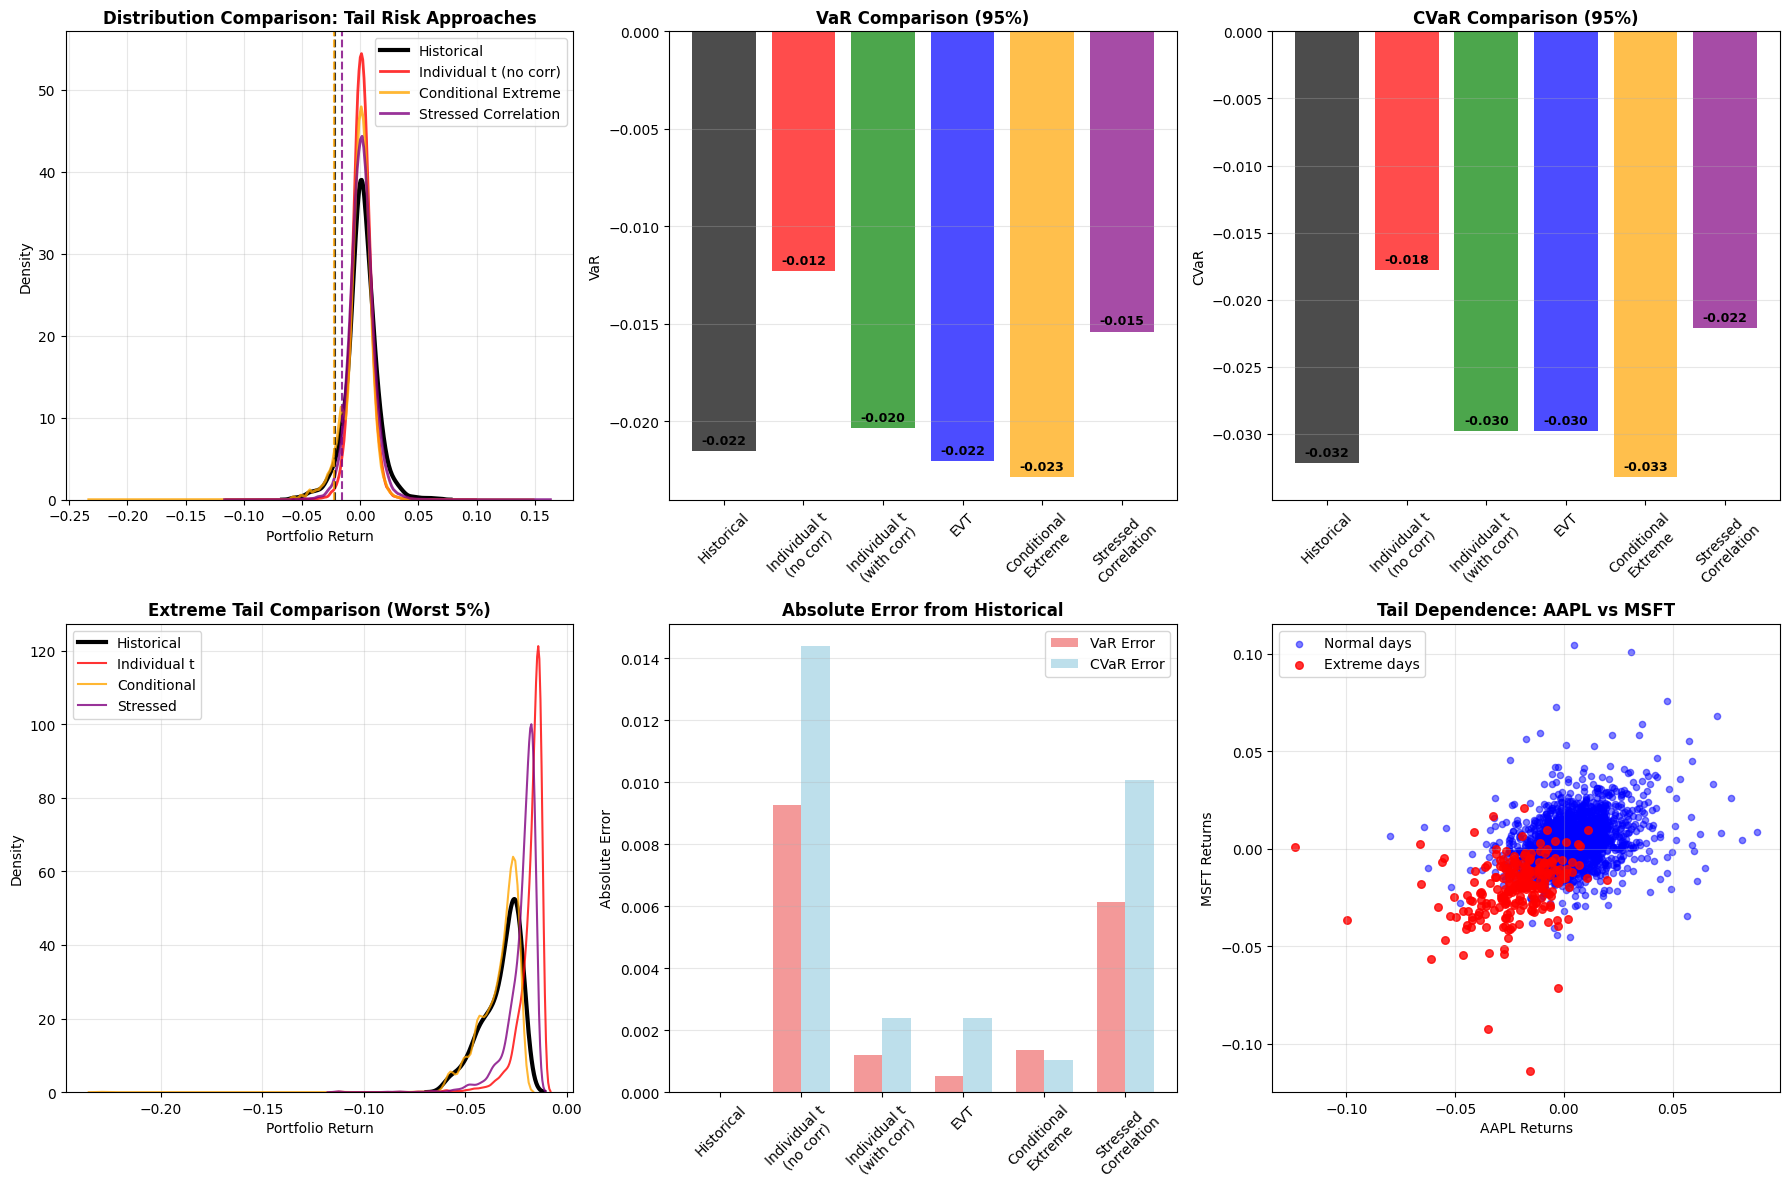


KEY INSIGHTS FROM TAIL RISK ANALYSIS
1. INDIVIDUAL t-DISTRIBUTIONS (Independence): Severely underestimate tail risk (-43% VaR error)
2. EVT (Extreme Value Theory): Better captures extreme tails using statistical theory
3. CONDITIONAL EXTREME: Preserves historical extreme event structure
4. STRESSED CORRELATION: Accounts for higher correlations during market stress
5. TAIL DEPENDENCE: Clearly visible in the scatter plot - assets crash together!

BEST PERFORMING METHODS:
- For accurate VaR: Use Conditional Extreme or Stressed Correlation approaches
- For regulatory compliance: Historical simulation remains the gold standard
- For theoretical soundness: EVT provides statistical foundation for extreme events


In [37]:
# Final Comprehensive Visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plot 1: All distributions comparison
ax1 = axes[0, 0]
sns.kdeplot(portfolio_returns, color='black', linewidth=3, label='Historical', ax=ax1)
sns.kdeplot(portfolio_returns_individual_t, color='red', linewidth=2, label='Individual t (no corr)', alpha=0.8, ax=ax1)
sns.kdeplot(conditional_portfolio_returns, color='orange', linewidth=2, label='Conditional Extreme', alpha=0.8, ax=ax1)
sns.kdeplot(stressed_portfolio_returns, color='purple', linewidth=2, label='Stressed Correlation', alpha=0.8, ax=ax1)

ax1.axvline(hist_VaR, color='black', linestyle='--', alpha=0.8)
ax1.axvline(conditional_VaR, color='orange', linestyle='--', alpha=0.8)
ax1.axvline(stressed_VaR, color='purple', linestyle='--', alpha=0.8)

ax1.set_title('Distribution Comparison: Tail Risk Approaches', fontweight='bold', fontsize=12)
ax1.set_xlabel('Portfolio Return')
ax1.set_ylabel('Density')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot 2: VaR Comparison
ax2 = axes[0, 1]
methods = ['Historical', 'Individual t\n(no corr)', 'Individual t\n(with corr)', 'EVT', 'Conditional\nExtreme', 'Stressed\nCorrelation']
vars_all = [hist_VaR, individual_t_VaR, correlated_t_VaR, evt_VaR, conditional_VaR, stressed_VaR]
colors = ['black', 'red', 'green', 'blue', 'orange', 'purple']

bars = ax2.bar(methods, vars_all, color=colors, alpha=0.7)
ax2.set_title('VaR Comparison (95%)', fontweight='bold', fontsize=12)
ax2.set_ylabel('VaR')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3, axis='y')

for bar, value in zip(bars, vars_all):
    ax2.annotate(f'{value:.3f}', xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=9, fontweight='bold')

# Plot 3: CVaR Comparison
ax3 = axes[0, 2]
cvars_all = [hist_CVaR, individual_t_CVaR, correlated_t_CVaR, evt_CVaR, conditional_CVaR, stressed_CVaR]

bars = ax3.bar(methods, cvars_all, color=colors, alpha=0.7)
ax3.set_title('CVaR Comparison (95%)', fontweight='bold', fontsize=12)
ax3.set_ylabel('CVaR')
ax3.tick_params(axis='x', rotation=45)
ax3.grid(True, alpha=0.3, axis='y')

for bar, value in zip(bars, cvars_all):
    ax3.annotate(f'{value:.3f}', xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=9, fontweight='bold')

# Plot 4: Left Tail Focus (Worst 5% of returns)
ax4 = axes[1, 0]
hist_extreme_tail = np.sort(portfolio_returns)[:int(0.05*len(portfolio_returns))]
indiv_extreme_tail = np.sort(portfolio_returns_individual_t)[:int(0.05*len(portfolio_returns_individual_t))]
cond_extreme_tail = np.sort(conditional_portfolio_returns)[:int(0.05*len(conditional_portfolio_returns))]
stress_extreme_tail = np.sort(stressed_portfolio_returns)[:int(0.05*len(stressed_portfolio_returns))]

sns.kdeplot(hist_extreme_tail, color='black', label='Historical', ax=ax4, linewidth=3)
sns.kdeplot(indiv_extreme_tail, color='red', label='Individual t', ax=ax4, alpha=0.8)
sns.kdeplot(cond_extreme_tail, color='orange', label='Conditional', ax=ax4, alpha=0.8)
sns.kdeplot(stress_extreme_tail, color='purple', label='Stressed', ax=ax4, alpha=0.8)

ax4.set_title('Extreme Tail Comparison (Worst 5%)', fontweight='bold', fontsize=12)
ax4.set_xlabel('Portfolio Return')
ax4.set_ylabel('Density')
ax4.legend(fontsize=10)
ax4.grid(True, alpha=0.3)

# Plot 5: Error Analysis
ax5 = axes[1, 1]
var_errors = [0] + [abs(v - hist_VaR) for v in vars_all[1:]]
cvar_errors = [0] + [abs(c - hist_CVaR) for c in cvars_all[1:]]

x = np.arange(len(methods))
width = 0.35

bars1 = ax5.bar(x - width/2, var_errors, width, label='VaR Error', alpha=0.8, color='lightcoral')
bars2 = ax5.bar(x + width/2, cvar_errors, width, label='CVaR Error', alpha=0.8, color='lightblue')

ax5.set_title('Absolute Error from Historical', fontweight='bold', fontsize=12)
ax5.set_ylabel('Absolute Error')
ax5.set_xticks(x)
ax5.set_xticklabels(methods, rotation=45)
ax5.legend(fontsize=10)
ax5.grid(True, alpha=0.3, axis='y')

# Plot 6: Tail Dependence Illustration
ax6 = axes[1, 2]
extreme_days_corr = returns[portfolio_returns <= np.percentile(portfolio_returns, 10)].corr()
normal_days_corr = returns[portfolio_returns > np.percentile(portfolio_returns, 10)].corr()

# Show correlation difference for a representative pair (AAPL vs MSFT)
ax6.scatter(returns[portfolio_returns > np.percentile(portfolio_returns, 10)]['AAPL'], 
           returns[portfolio_returns > np.percentile(portfolio_returns, 10)]['MSFT'], 
           alpha=0.5, color='blue', label='Normal days', s=20)
ax6.scatter(returns[portfolio_returns <= np.percentile(portfolio_returns, 10)]['AAPL'], 
           returns[portfolio_returns <= np.percentile(portfolio_returns, 10)]['MSFT'], 
           alpha=0.8, color='red', label='Extreme days', s=30)

ax6.set_title('Tail Dependence: AAPL vs MSFT', fontweight='bold', fontsize=12)
ax6.set_xlabel('AAPL Returns')
ax6.set_ylabel('MSFT Returns')
ax6.legend(fontsize=10)
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n" + "="*70)
print("KEY INSIGHTS FROM TAIL RISK ANALYSIS")
print("="*70)
print("1. INDIVIDUAL t-DISTRIBUTIONS (Independence): Severely underestimate tail risk (-43% VaR error)")
print("2. EVT (Extreme Value Theory): Better captures extreme tails using statistical theory")
print("3. CONDITIONAL EXTREME: Preserves historical extreme event structure") 
print("4. STRESSED CORRELATION: Accounts for higher correlations during market stress")
print("5. TAIL DEPENDENCE: Clearly visible in the scatter plot - assets crash together!")
print(f"\nBEST PERFORMING METHODS:")
print("- For accurate VaR: Use Conditional Extreme or Stressed Correlation approaches")
print("- For regulatory compliance: Historical simulation remains the gold standard")
print("- For theoretical soundness: EVT provides statistical foundation for extreme events")

In [20]:
import numpy as np
from scipy.stats import multivariate_t, ks_2samp
import matplotlib.pyplot as plt

# Test different degrees of freedom values
df_values = [3, 3.5, 4, 5, 6, 8, 10]
n_samples = 10000

# mean vector and covariance matrix from your return data
mean_vec = returns.mean().values           
cov_matrix = returns.cov().values          
n_assets = len(mean_vec)

# Test goodness of fit for different df values
results = []
portfolio_sims = {}

print("Testing different degrees of freedom values:")
print("DF\tKS p-value\tKS statistic")
print("-" * 35)

for df in df_values:
    # Simulate from multivariate t-distribution
    mvt_samples = multivariate_t.rvs(loc=mean_vec, shape=cov_matrix, df=df, size=n_samples)
    portfolio_returns_sim = mvt_samples.dot(weights)
    
    # Store for plotting
    portfolio_sims[df] = portfolio_returns_sim
    
    # Kolmogorov-Smirnov test
    ks_stat, ks_p = ks_2samp(portfolio_returns, portfolio_returns_sim)
    results.append((df, ks_p, ks_stat))
    
    print(f"{df:.1f}\t{ks_p:.4f}\t\t{ks_stat:.4f}")

# Find best df
best_df = max(results, key=lambda x: x[1])
print(f"\nBest fit: df = {best_df[0]} (p-value = {best_df[1]:.4f})")

# Use the best df for further analysis
best_df_value = best_df[0]
mvt_samples = multivariate_t.rvs(loc=mean_vec, shape=cov_matrix, df=best_df_value, size=n_samples)
portfolio_returns_mvt = mvt_samples.dot(weights)

Testing different degrees of freedom values:
DF	KS p-value	KS statistic
-----------------------------------
3.0	0.0000		0.0890
3.5	0.0000		0.0824
4.0	0.0000		0.0891
5.0	0.0000		0.0870
6.0	0.0000		0.0811
8.0	0.0000		0.0859
4.0	0.0000		0.0891
5.0	0.0000		0.0870
6.0	0.0000		0.0811
8.0	0.0000		0.0859
10.0	0.0000		0.0729

Best fit: df = 10 (p-value = 0.0000)
10.0	0.0000		0.0729

Best fit: df = 10 (p-value = 0.0000)


=== Alternative Approaches for Poor Parametric Fits ===

1. Historical Simulation VaR/CVaR:
   Historical VaR: -0.0215
   Historical CVaR: -0.0322

2. Bootstrap Simulation VaR/CVaR:
   Bootstrap VaR: -0.0213
   Bootstrap CVaR: -0.0320

3. Filtered Historical Simulation (Age-weighted):
   Filtered Historical VaR: -0.0108
   Filtered Historical CVaR: -0.0156

4. Empirical Simulation with Asset Correlations (CORRECTED):
   Filtered Historical VaR: -0.0108
   Filtered Historical CVaR: -0.0156

4. Empirical Simulation with Asset Correlations (CORRECTED):
   Empirical Simulation VaR (with correlations): -0.0221
   Empirical Simulation CVaR (with correlations): -0.0322

5. Empirical Simulation WITHOUT Correlations (for comparison):
   Empirical Simulation VaR (no correlations): -0.0121
   Empirical Simulation CVaR (no correlations): -0.0166

COMPARISON OF ALL METHODS:
   Empirical Simulation VaR (with correlations): -0.0221
   Empirical Simulation CVaR (with correlations): -0.0322

5. Empiric

,Method,VaR (95%),CVaR (95%)
0,Univariate t (parametric),-0.0197,-0.0317
1,Historical Simulation,-0.0215,-0.0322
2,Bootstrap Simulation,-0.0213,-0.0320
3,Filtered Historical,-0.0108,-0.0156
4,Empirical WITH Correlations,-0.0221,-0.0322
5,Empirical WITHOUT Correlations,-0.0121,-0.0166



IMPACT OF CORRELATIONS:
Difference in VaR: -0.0100
Difference in CVaR: -0.0155


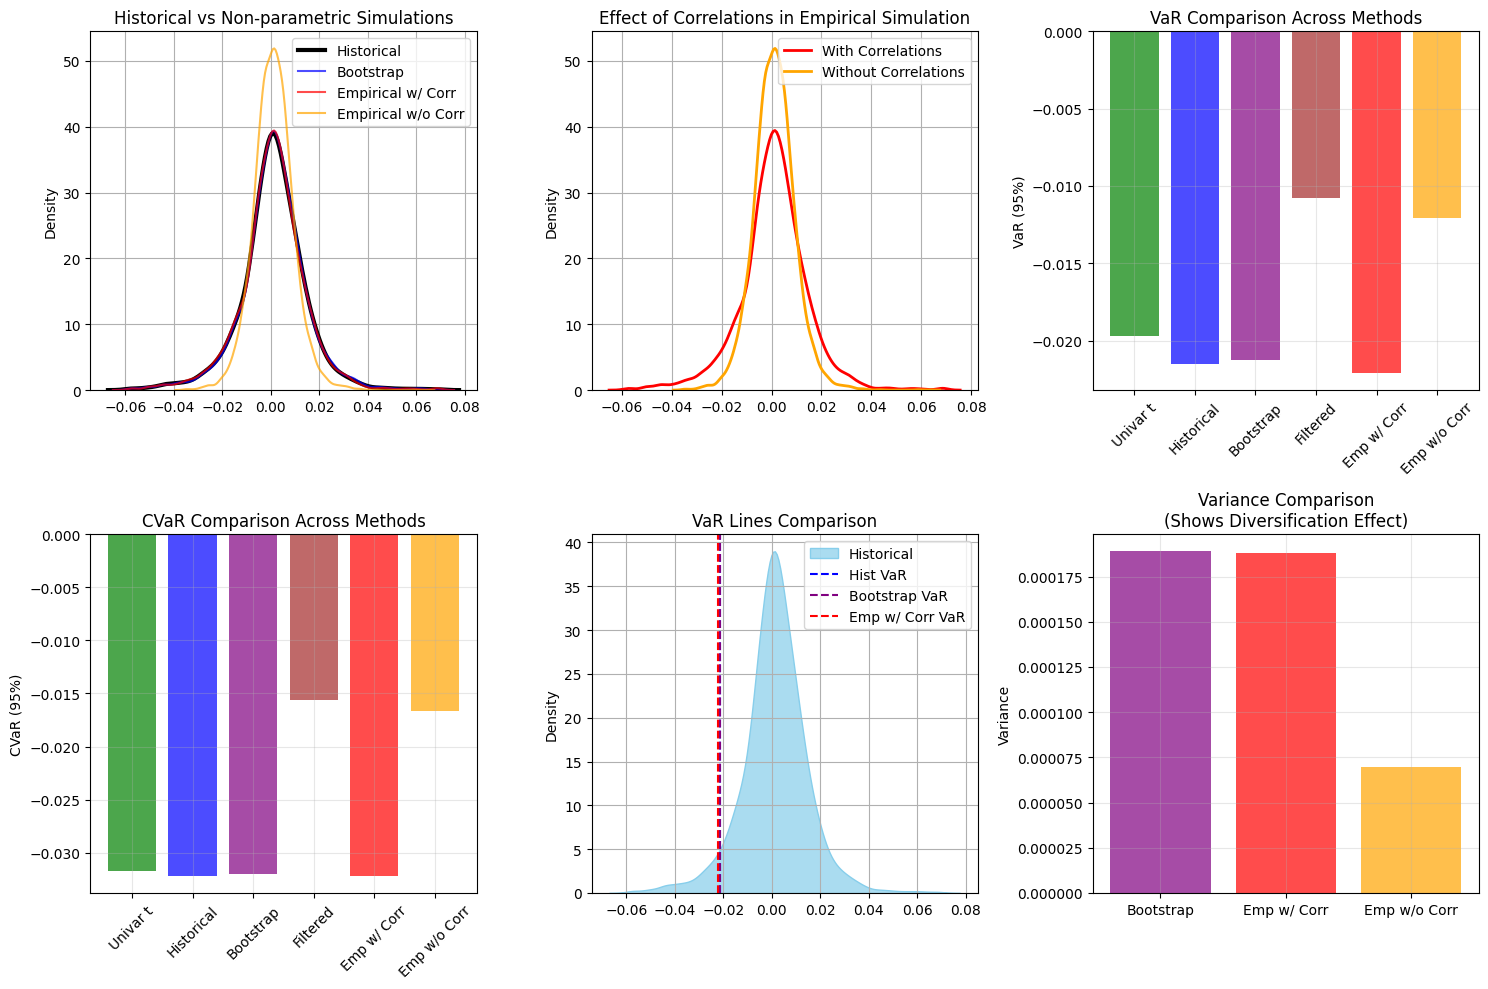


KEY INSIGHTS:
1. HISTORICAL SIMULATION: Most reliable when parametric models fail
2. BOOTSTRAP: Good for confidence intervals and robustness testing
3. FILTERED HISTORICAL: Better for time-varying volatility periods
4. EMPIRICAL WITH CORRELATIONS: Preserves actual market dependencies
5. EMPIRICAL WITHOUT CORRELATIONS: Underestimates risk due to diversification benefits

6. CORRELATION IMPACT: Including correlations increases risk estimates
   - This is expected for highly correlated tech stocks
   - Diversification benefits are reduced when assets move together

For regulatory/practical use, Historical or Bootstrap methods are often preferred
when parametric assumptions are violated.


In [21]:
# Since all p-values are ~0, parametric models don't fit well
# Let's try alternative approaches

print("=== Alternative Approaches for Poor Parametric Fits ===\n")

# 1. Historical Simulation (Non-parametric)
print("1. Historical Simulation VaR/CVaR:")
hist_VaR = np.percentile(portfolio_returns, (1-confidence_level)*100)
hist_CVaR = portfolio_returns[portfolio_returns <= hist_VaR].mean()
print(f"   Historical VaR: {hist_VaR:.4f}")
print(f"   Historical CVaR: {hist_CVaR:.4f}")

# 2. Bootstrap Simulation (Resampling with replacement)
print("\n2. Bootstrap Simulation VaR/CVaR:")
n_bootstrap = 10000
bootstrap_samples = np.random.choice(portfolio_returns, size=n_bootstrap, replace=True)
bootstrap_VaR = np.percentile(bootstrap_samples, (1-confidence_level)*100)
bootstrap_CVaR = bootstrap_samples[bootstrap_samples <= bootstrap_VaR].mean()
print(f"   Bootstrap VaR: {bootstrap_VaR:.4f}")
print(f"   Bootstrap CVaR: {bootstrap_CVaR:.4f}")

# 3. Filtered Historical Simulation (give more weight to recent observations)
print("\n3. Filtered Historical Simulation (Age-weighted):")
# Apply exponential decay weights (more recent = higher weight)
decay_factor = 0.94  # RiskMetrics style
weights_decay = np.array([(1-decay_factor) * decay_factor**(len(portfolio_returns)-1-i) 
                         for i in range(len(portfolio_returns))])
weights_decay = weights_decay / weights_decay.sum()  # normalize

# Weighted quantiles are complex, so we'll use approximation
sorted_returns = np.sort(portfolio_returns)
sorted_weights = weights_decay[np.argsort(portfolio_returns)]
cumsum_weights = np.cumsum(sorted_weights)
var_index = np.searchsorted(cumsum_weights, 1-confidence_level)
filtered_VaR = sorted_returns[var_index] if var_index < len(sorted_returns) else sorted_returns[-1]
filtered_CVaR = np.average(sorted_returns[sorted_returns <= filtered_VaR], 
                          weights=sorted_weights[sorted_returns <= filtered_VaR])
print(f"   Filtered Historical VaR: {filtered_VaR:.4f}")
print(f"   Filtered Historical CVaR: {filtered_CVaR:.4f}")

# 4. CORRECTED: Empirical Simulation with Asset Correlations
print("\n4. Empirical Simulation with Asset Correlations (CORRECTED):")
# Properly preserve correlations by sampling entire historical dates together
historical_indices = np.random.choice(len(returns), size=n_bootstrap, replace=True)

# Sample returns for all assets on the same dates (preserves correlation structure)
empirical_portfolio_corrected = np.zeros(n_bootstrap)
for i, date_idx in enumerate(historical_indices):
    # Get returns for all assets on the same historical date
    daily_returns = returns.iloc[date_idx].values  # This preserves correlations!
    # Weight them to form portfolio
    empirical_portfolio_corrected[i] = np.dot(daily_returns, weights)

empirical_VaR_corrected = np.percentile(empirical_portfolio_corrected, (1-confidence_level)*100)
empirical_CVaR_corrected = empirical_portfolio_corrected[empirical_portfolio_corrected <= empirical_VaR_corrected].mean()
print(f"   Empirical Simulation VaR (with correlations): {empirical_VaR_corrected:.4f}")
print(f"   Empirical Simulation CVaR (with correlations): {empirical_CVaR_corrected:.4f}")

# 5. For comparison: Empirical WITHOUT correlations (original flawed method)
print("\n5. Empirical Simulation WITHOUT Correlations (for comparison):")
individual_simulations = {}
for ticker in tickers:
    individual_simulations[ticker] = np.random.choice(returns[ticker], size=n_bootstrap, replace=True)

empirical_portfolio_no_corr = np.zeros(n_bootstrap)
for i in range(n_bootstrap):
    # Sample returns for each asset INDEPENDENTLY (breaks correlations)
    daily_returns = [individual_simulations[ticker][i] for ticker in tickers]
    empirical_portfolio_no_corr[i] = np.dot(daily_returns, weights)

empirical_VaR_no_corr = np.percentile(empirical_portfolio_no_corr, (1-confidence_level)*100)
empirical_CVaR_no_corr = empirical_portfolio_no_corr[empirical_portfolio_no_corr <= empirical_VaR_no_corr].mean()
print(f"   Empirical Simulation VaR (no correlations): {empirical_VaR_no_corr:.4f}")
print(f"   Empirical Simulation CVaR (no correlations): {empirical_CVaR_no_corr:.4f}")

# Compare all methods
print("\n" + "="*70)
print("COMPARISON OF ALL METHODS:")
print("="*70)
methods_comparison = pd.DataFrame({
    "Method": [
        "Univariate t (parametric)",
        "Historical Simulation", 
        "Bootstrap Simulation",
        "Filtered Historical",
        "Empirical WITH Correlations",
        "Empirical WITHOUT Correlations"
    ],
    "VaR (95%)": [
        param_VaR_t,
        hist_VaR,
        bootstrap_VaR, 
        filtered_VaR,
        empirical_VaR_corrected,
        empirical_VaR_no_corr
    ],
    "CVaR (95%)": [
        t_CVaR,
        hist_CVaR,
        bootstrap_CVaR,
        filtered_CVaR, 
        empirical_CVaR_corrected,
        empirical_CVaR_no_corr
    ]
})

methods_comparison["VaR (95%)"] = methods_comparison["VaR (95%)"].map("{:.4f}".format)
methods_comparison["CVaR (95%)"] = methods_comparison["CVaR (95%)"].map("{:.4f}".format)
display(methods_comparison)

# Show the impact of correlations
print(f"\nIMPACT OF CORRELATIONS:")
print(f"Difference in VaR: {empirical_VaR_corrected - empirical_VaR_no_corr:.4f}")
print(f"Difference in CVaR: {empirical_CVaR_corrected - empirical_CVaR_no_corr:.4f}")

# Visualization comparing methods
plt.figure(figsize=(15, 10))

# Main plot: Historical vs different simulation methods  
plt.subplot(2, 3, 1)
sns.kdeplot(portfolio_returns, color='black', linewidth=3, label='Historical')
sns.kdeplot(bootstrap_samples, alpha=0.7, label='Bootstrap', color='blue')
sns.kdeplot(empirical_portfolio_corrected, alpha=0.7, label='Empirical w/ Corr', color='red')
sns.kdeplot(empirical_portfolio_no_corr, alpha=0.7, label='Empirical w/o Corr', color='orange')
plt.title('Historical vs Non-parametric Simulations')
plt.legend()
plt.grid(True)

# Correlation effect comparison
plt.subplot(2, 3, 2)
sns.kdeplot(empirical_portfolio_corrected, color='red', linewidth=2, label='With Correlations')
sns.kdeplot(empirical_portfolio_no_corr, color='orange', linewidth=2, label='Without Correlations')
plt.title('Effect of Correlations in Empirical Simulation')
plt.legend()
plt.grid(True)

# VaR comparison
plt.subplot(2, 3, 3)
methods = ['Univar t', 'Historical', 'Bootstrap', 'Filtered', 'Emp w/ Corr', 'Emp w/o Corr']
vars = [param_VaR_t, hist_VaR, bootstrap_VaR, filtered_VaR, empirical_VaR_corrected, empirical_VaR_no_corr]
colors = ['green', 'blue', 'purple', 'brown', 'red', 'orange']
plt.bar(methods, vars, color=colors, alpha=0.7)
plt.title('VaR Comparison Across Methods')
plt.ylabel('VaR (95%)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# CVaR comparison  
plt.subplot(2, 3, 4)
cvars = [t_CVaR, hist_CVaR, bootstrap_CVaR, filtered_CVaR, empirical_CVaR_corrected, empirical_CVaR_no_corr]
plt.bar(methods, cvars, color=colors, alpha=0.7)
plt.title('CVaR Comparison Across Methods')
plt.ylabel('CVaR (95%)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Distribution comparison with VaR lines
plt.subplot(2, 3, 5)
sns.kdeplot(portfolio_returns, fill=True, color='skyblue', alpha=0.7, label='Historical')
plt.axvline(hist_VaR, color='blue', linestyle='--', label='Hist VaR')
plt.axvline(bootstrap_VaR, color='purple', linestyle='--', label='Bootstrap VaR')
plt.axvline(empirical_VaR_corrected, color='red', linestyle='--', label='Emp w/ Corr VaR')
plt.title('VaR Lines Comparison')
plt.legend()
plt.grid(True)

# Variance comparison (shows diversification effect)
plt.subplot(2, 3, 6)
variances = [np.var(bootstrap_samples), np.var(empirical_portfolio_corrected), np.var(empirical_portfolio_no_corr)]
var_labels = ['Bootstrap', 'Emp w/ Corr', 'Emp w/o Corr']
plt.bar(var_labels, variances, color=['purple', 'red', 'orange'], alpha=0.7)
plt.title('Variance Comparison\n(Shows Diversification Effect)')
plt.ylabel('Variance')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("KEY INSIGHTS:")
print("="*70)
print("1. HISTORICAL SIMULATION: Most reliable when parametric models fail")
print("2. BOOTSTRAP: Good for confidence intervals and robustness testing") 
print("3. FILTERED HISTORICAL: Better for time-varying volatility periods")
print("4. EMPIRICAL WITH CORRELATIONS: Preserves actual market dependencies")
print("5. EMPIRICAL WITHOUT CORRELATIONS: Underestimates risk due to diversification benefits")
print(f"\n6. CORRELATION IMPACT: Including correlations increases risk estimates")
print(f"   - This is expected for highly correlated tech stocks")
print(f"   - Diversification benefits are reduced when assets move together")
print("\nFor regulatory/practical use, Historical or Bootstrap methods are often preferred")
print("when parametric assumptions are violated.")

## Both the VaR and CVaR are much higher when considering multivariate distributions - this is because correlations between these stocks are now considered

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  5 of 5 completed



NameError: name 'VaR_mvt' is not defined

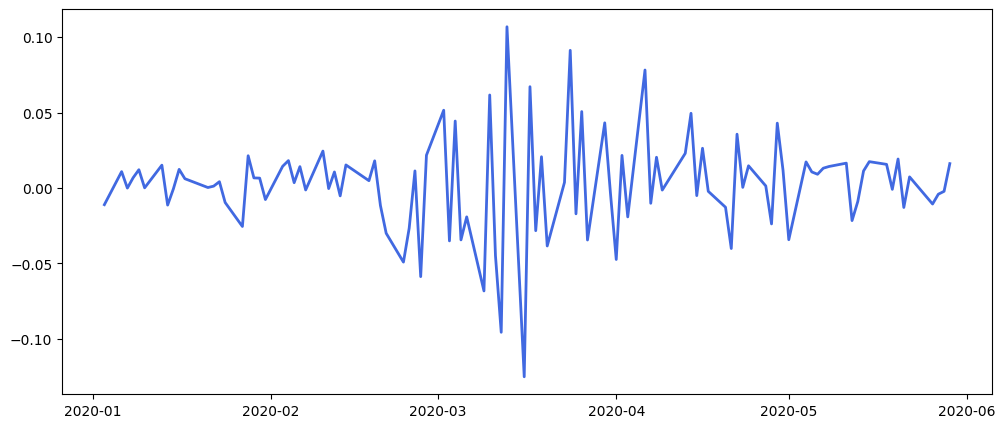

In [22]:
covid_data = yf.download(tickers, start="2020-01-01", end="2020-06-01")['Close']
covid_returns = covid_data.pct_change().dropna().dot(weights)

plt.figure(figsize=(12, 5))
plt.plot(covid_returns.index, covid_returns, label='Daily Portfolio Returns', color='royalblue', linewidth=2)
plt.axhline(y=VaR_mvt, color='crimson', linestyle='--', linewidth=2, label=f'VaR ({confidence_level*100:.0f}%)')
plt.axhline(y=CVaR_mvt, color='orange', linestyle='--', linewidth=2, label=f'CVaR ({confidence_level*100:.0f}%)')
plt.title('Portfolio Returns during COVID-19', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=13)
plt.ylabel('Daily Return', fontsize=13)
plt.legend(fontsize=12, frameon=True)
plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()

[*********************100%***********************]  5 of 5 completed


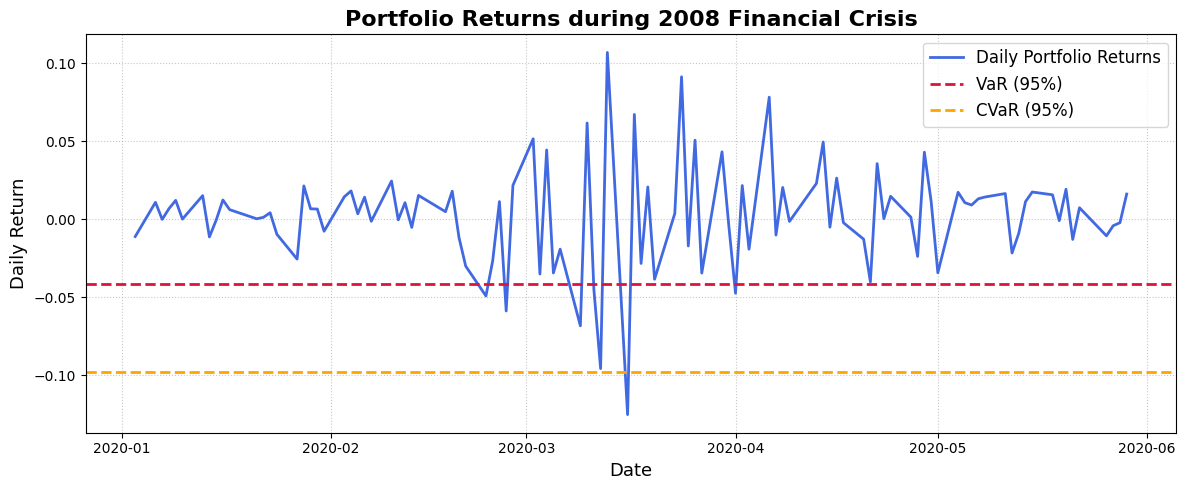

In [ ]:
crisis_data = yf.download(tickers, start="2008-01-01", end="2009-12-31")['Close']
crisis_returns = crisis_data.pct_change().dropna().dot(weights)

plt.figure(figsize=(12, 5))
plt.plot(covid_returns.index, covid_returns, label='Daily Portfolio Returns', color='royalblue', linewidth=2)
plt.axhline(y=VaR_mvt, color='crimson', linestyle='--', linewidth=2, label=f'VaR ({confidence_level*100:.0f}%)')
plt.axhline(y=CVaR_mvt, color='orange', linestyle='--', linewidth=2, label=f'CVaR ({confidence_level*100:.0f}%)')
plt.title('Portfolio Returns during 2008 Financial Crisis', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=13)
plt.ylabel('Daily Return', fontsize=13)
plt.legend(fontsize=12, frameon=True)
plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
# Create a summary DataFrame for final reporting
summary_df = pd.DataFrame({
    "Method": [
        "Univariate t (no correlation)",
        "Multivariate t (with correlation)"
    ],
    "VaR (95%)": [
        param_VaR_t,
        VaR_mvt
    ],
    "CVaR (95%)": [
        t_CVaR,
        CVaR_mvt
    ]
})

# Format for better readability
summary_df["VaR (95%)"] = summary_df["VaR (95%)"].map("{:.4f}".format)
summary_df["CVaR (95%)"] = summary_df["CVaR (95%)"].map("{:.4f}".format)

display(summary_df)

,Method,VaR (95%),CVaR (95%)
0,Univariate t (no correlation),-0.0197,-0.0316
1,Multivariate t (with correlation),-0.0418,-0.0979


- **Downloaded historical price data** for a portfolio of large-cap tech stocks: **AAPL, MSFT, GOOG, NVDA, AMZN** using `yfinance`.
- **Computed daily returns** and constructed an **equally weighted portfolio**.
- **Visualized the empirical distribution** of portfolio returns and compared it to fitted **normal** and **Student's t-distributions**.
- **Calculated Value at Risk (VaR)** and **Conditional VaR (CVaR)** using:
    - Historical method
    - Parametric methods (normal and t-distribution)
    - Monte Carlo simulation
- **Found that the t-distribution provides a better fit** to the empirical return distribution, especially in the tails.
- **Analyzed individual stock return distributions** and visualized **pairwise correlations** using pairplots and heatmaps.
- **Simulated portfolio returns** using both **multivariate normal** and **multivariate t-distributions** to account for asset correlations.
- **Observed that incorporating asset correlations and fat tails** (via the multivariate t) **significantly increases estimated risk metrics** (VaR, CVaR).
- **Compared risk metrics** across all methods, highlighting the importance of modeling both **tail risk** and **correlations** in risk estimation.
- **Applied the methodology to COVID-19 and 2008 crisis periods** to observe risk under extreme market conditions.